In [252]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras import layers, models, applications, losses
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, TFAutoModel, AlbertConfig
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
from collections import Counter
from itertools import cycle
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, f1_score
import optuna
from optuna.visualization.matplotlib import *

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 4
RANDOM_STATE = 42

# Main task

## PDA

### Load data

In [2]:
# Get all classes present
with open('main/techniques_list_task3.txt', 'r') as file:
    # Read each line and store them as elements in a list
    techniques = [line.strip() for line in file if line.strip()]

techniques


['Appeal to authority',
 'Appeal to fear/prejudice',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism',
 'Bandwagon',
 'Transfer',
 'Appeal to (Strong) Emotions']

In [3]:
len(techniques)

22

In this code, subtask 3 is renamed to main, while subtask 2 is renamed to enhancement

In [4]:
# Get data
with open('main/training_set_task3/training_set_task3.txt', 'r') as file:
    train_json = json.load(file)

with open('main/test_set_task3/test_set_task3.txt', 'r') as file:
    test_json = json.load(file)

with open('main/dev_set_task3_labeled/dev_set_task3_labeled.txt', 'r') as file:
    dev_json = json.load(file)
    
# Convert to dataframe
train_df = pd.DataFrame(train_json)
test_df = pd.DataFrame(test_json)
dev_df = pd.DataFrame(dev_json)

In [5]:
train_df.head()

id                                             labels  \
0  128  [Black-and-white Fallacy/Dictatorship, Name ca...   
1  189           [Reductio ad hitlerum, Smears, Transfer]   
2   96  [Appeal to fear/prejudice, Loaded Language, Na...   
3  154  [Causal Oversimplification, Glittering general...   
4   15  [Flag-waving, Misrepresentation of Someone's P...   

                                                text          image  
0    THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n  128_image.png  
1                           This is not an accident!  189_image.png  
2  SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...   96_image.png  
3  PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...  154_image.png  
4  WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n   15_image.png

In [6]:
test_df.head()

id                                             labels  \
0  705_batch_2  [Name calling/Labeling, Slogans, Smears, Trans...   
1  706_batch_2  [Appeal to (Strong) Emotions, Appeal to fear/p...   
2  710_batch_2    [Doubt, Loaded Language, Name calling/Labeling]   
3  713_batch_2       [Exaggeration/Minimisation, Loaded Language]   
4  715_batch_2                                            [Doubt]   

                                                text                  image  
0                        The Democrats New America\n  705_image_batch_2.png  
1  WE ARE AT WAR!\n\nThere is a complex assault o...  706_image_batch_2.png  
2  KILLED HIMSELF IN PRISON\n\nWON AN HONEST ELEC...  710_image_batch_2.png  
3  I will never concede!\n\nNO WAY IN HELL BIDEN ...  713_image_batch_2.png  
4  TRYING TO FIGURE OUT HOW BIDEN WON A RECORD LO...  715_image_batch_2.png

In [7]:
dev_df.head()

id                                             labels  \
0   62_batch_2                                    [Smears, Doubt]   
1  111_batch_2   [Smears, Loaded Language, Name calling/Labeling]   
2  167_batch_2                                 [Smears, Transfer]   
3   93_batch_2                                                 []   
4  153_batch_2  [Smears, Exaggeration/Minimisation, Loaded Lan...   

                                                text                  image  
0                *President* Biden?\n\nPlease, no.\n   62_image_batch_2.png  
1  JOE  VERSUS THE VOLCANIC KREMLIN DON\n\n"WILL ...  111_image_batch_2.png  
2  ANTI-VAXXERS BE LIKE... \n\nHANG ON A SEC - JU...  167_image_batch_2.png  
3                       VIRUS BINGO\nFREE 32 SPACE\n   93_image_batch_2.png  
4  Never thought l'd die fighting IRRESPONSIBLY R...  153_image_batch_2.png

Each DataFrame includes the image name, corresponding text, and labels associated with each image. To load the images, concatenate the image name with the directory path to form the full file path. Note that there is currently an `ID` column in the DataFrame, which is not needed and can be removed.

In [8]:
# Drop redundant columns
train_df = train_df.drop(['id'], axis=1)
test_df = test_df.drop(['id'], axis=1)
dev_df = dev_df.drop(['id'], axis=1)

In [9]:
train_df.head()

labels  \
0  [Black-and-white Fallacy/Dictatorship, Name ca...   
1           [Reductio ad hitlerum, Smears, Transfer]   
2  [Appeal to fear/prejudice, Loaded Language, Na...   
3  [Causal Oversimplification, Glittering general...   
4  [Flag-waving, Misrepresentation of Someone's P...   

                                                text          image  
0    THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n  128_image.png  
1                           This is not an accident!  189_image.png  
2  SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...   96_image.png  
3  PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...  154_image.png  
4  WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n   15_image.png

Since the `image` column in the DataFrame only contains the file names of the images, and we need the full path to load the images, we will concatenate the base directory path with each image name to form the complete file path.


In [10]:
train_df['image'] = train_df['image'].map(lambda x: 'main/training_set_task3/' + x)
test_df['image'] = test_df['image'].map(lambda x: 'main/test_set_task3/' + x)
dev_df['image'] = dev_df['image'].map(lambda x: 'main/dev_set_task3_labeled/' + x)

In [11]:
train_df.head()

labels  \
0  [Black-and-white Fallacy/Dictatorship, Name ca...   
1           [Reductio ad hitlerum, Smears, Transfer]   
2  [Appeal to fear/prejudice, Loaded Language, Na...   
3  [Causal Oversimplification, Glittering general...   
4  [Flag-waving, Misrepresentation of Someone's P...   

                                                text  \
0    THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n   
1                           This is not an accident!   
2  SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...   
3  PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...   
4  WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n   

                                   image  
0  main/training_set_task3/128_image.png  
1  main/training_set_task3/189_image.png  
2   main/training_set_task3/96_image.png  
3  main/training_set_task3/154_image.png  
4   main/training_set_task3/15_image.png

### Visualize an instance

In [12]:
# Get a random sample from train_df, test_df, and dev_df
all_df = pd.concat([train_df, test_df, dev_df])

TEXT: 
MAKE AMERICA GREAT AGAIN

A NATION WHOSE HEALTHCARE WORKERS DON'T HAVE MASKS TO KEEP THEM FROM GETTING SICK, ATTENDING TO PATIENTS WHO CAN'T GET VENTILATORS TO KEEP THEM ALIVE, SURROUNDED BY SICK PEOPLE WHO CAN'T GET TESTED, ISN'T GREAT
IT'S A DAMN DISGRACE.

LABELS:
['Flag-waving', 'Loaded Language', 'Slogans', 'Smears']


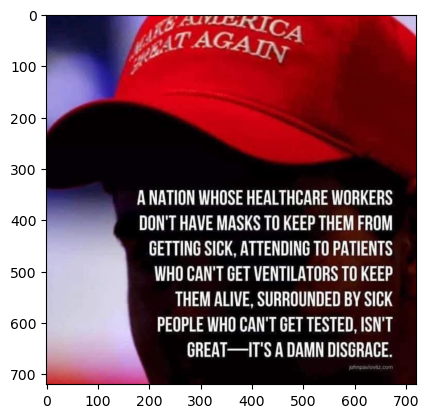

In [13]:
sample = all_df.sample(1)
plt.imshow(Image.open(sample['image'].values[0]))

print("TEXT: ")
print(sample['text'].values[0])
print("\nLABELS:")
print(sample['labels'].values[0])

According to the original competition from which the dataset was derived, the organizers specified that the last two techniques were reserved exclusively for images. They emphasized that "visual cues are used with text as a persuasive tool to spread disinformation," highlighting the critical role images play in conveying context. Therefore, in line with their approach, we will focus our investigation solely on images related to these two techniques to verify the extent to which images are indeed crucial for understanding and amplifying disinformation

TEXT: 
AMERICAN EXPERIENCE
THE GREAT WAR

LABELS:
['Flag-waving', 'Glittering generalities (Virtue)', 'Transfer']


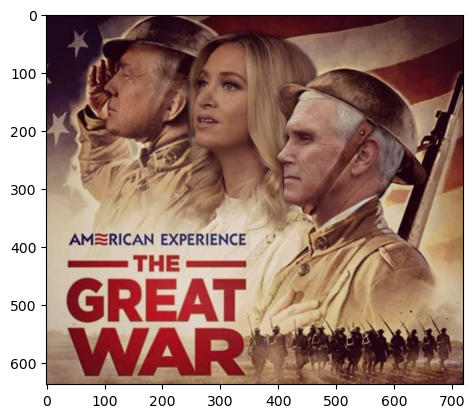

In [14]:
sample = all_df[all_df['labels'].apply(lambda x: "Transfer" in x)].sample(1)
plt.imshow(Image.open(sample['image'].values[0]))

print("TEXT: ")
print(sample['text'].values[0])
print("LABELS:")
print(sample['labels'].values[0])

TEXT: 
Researchers have developed a type of rice to combat Vitamin A deficiencies in poor countries that cause widespread blindness and over 600,000 childhood deaths annually.

The well fed people at Greenpeace oppose this. 
What kind of people are they?


LABELS:
['Appeal to (Strong) Emotions', 'Loaded Language', 'Name calling/Labeling', 'Smears']


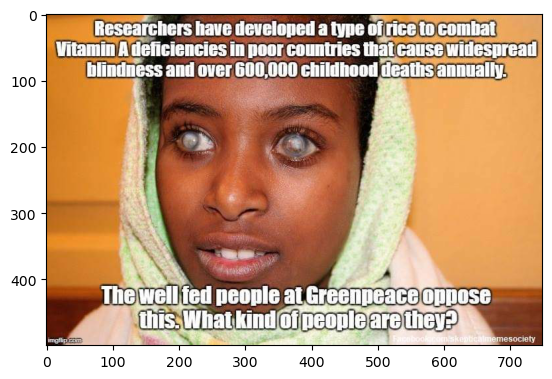

In [15]:
sample = all_df[all_df['labels'].apply(lambda x: "Appeal to (Strong) Emotions" in x)].sample(1)
plt.imshow(Image.open(sample['image'].values[0]))

print("TEXT: ")
print(sample['text'].values[0])
print("LABELS:")
print(sample['labels'].values[0])

We can see that images with these techniques are indeed crucial. For example, in this specific meme, the image of the land and Trump is required for understanding the meme:

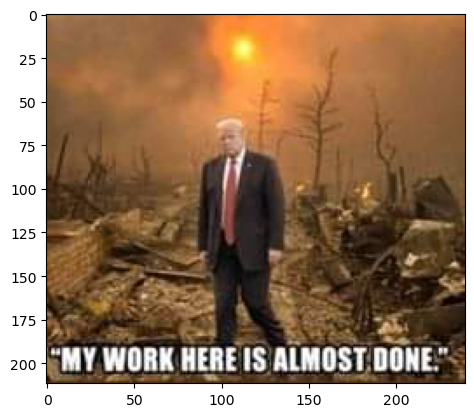

Additionally, just from the 2 images, we can see that images have different sizes, so during data preprocessing we will have to resize the images to the same size. For the size, we will choose 224x224 because it is the common size used in pretrained CNNs such as ResNet50

### Data distribution

In [16]:
# Function to plot label distribution
def plot_dist(df, title):
    all_labels = df['labels'].explode().tolist()

    # Count occurrences
    label_counts = Counter(all_labels)

    labels = [str(label) for label in label_counts.keys()]

    counts = label_counts.values()

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate labels for better readability
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

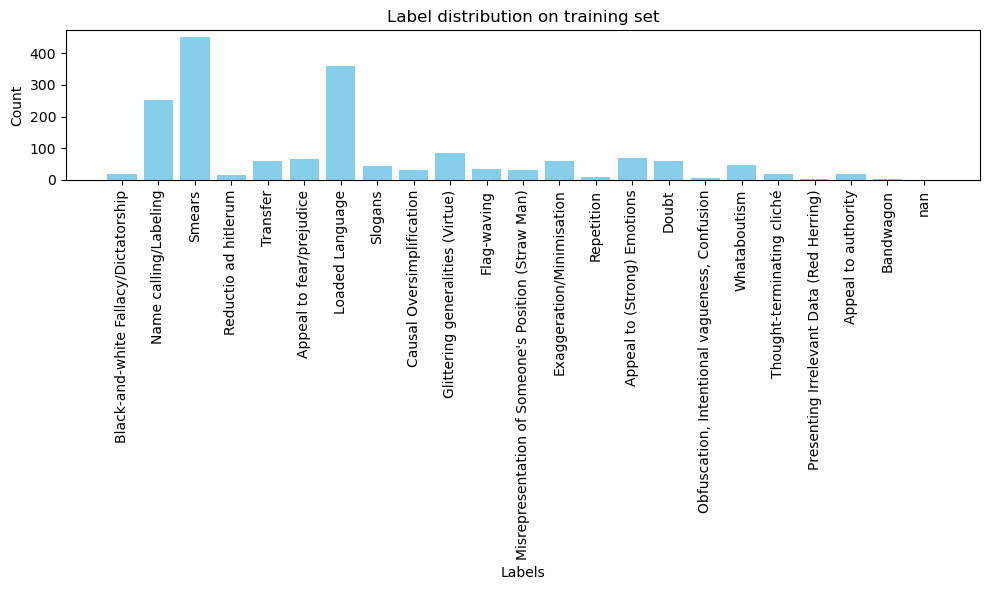

In [17]:
plot_dist(train_df, 'Label distribution on training set')

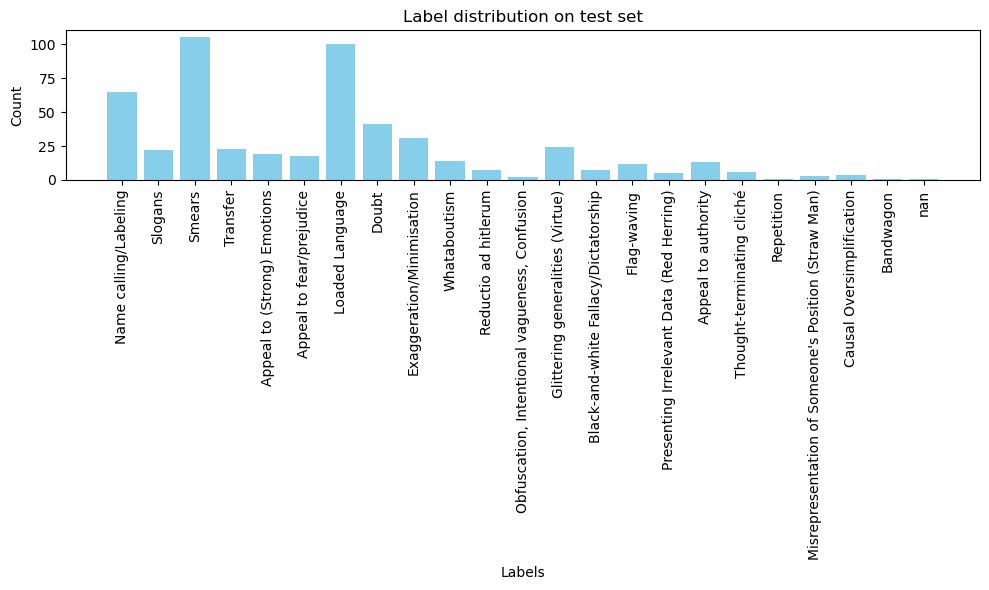

In [18]:
plot_dist(test_df, 'Label distribution on test set')

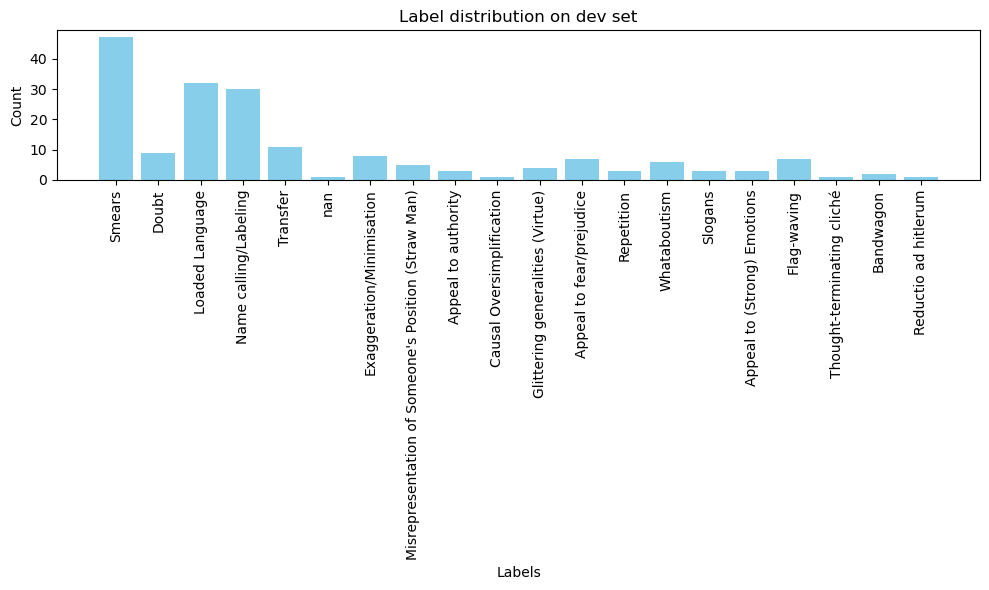

In [19]:
plot_dist(dev_df, 'Label distribution on dev set')

We observe the presence of `NaN` values among the classes. These `NaN` values may arise from rows with missing labels or from entries where the labels column contains an empty list. Therefore, for the next step, we will investigate thse missing values. 

In the training dataset, `Smears`, `Name Calling`, `Loaded Language` are the most common with over 200 entries, while some labels such as `Bandwagon`, or `Reptition` doesn't even have 10 entries. It is clear that the dataset is extremely unbalanced, therefore, we need someway to handle the imbalance problem. 

### Missing values

In [20]:
train_df.isna().sum()

labels    0
text      0
image     0
dtype: int64

In [21]:
test_df.isna().sum()

labels    0
text      0
image     0
dtype: int64

In [22]:
dev_df.isna().sum()

labels    0
text      0
image     0
dtype: int64

We have verified that there are no missing values in the training, test, and development dataframes. Consequently, the issue appears to be related to some entries containing empty lists in the values of the relevant column.

In [23]:
train_missing = train_df[train_df['labels'].apply(lambda x: x == [])]
len(train_missing)

29

In [24]:
test_missing = test_df[test_df['labels'].apply(lambda x: x == [])]
len(test_missing)

4

In [25]:
dev_missing = dev_df[dev_df['labels'].apply(lambda x: x == [])]
len(dev_missing)

3

TEXT: 
000 YOU ALMOST HAD IT


LABELS:
[]


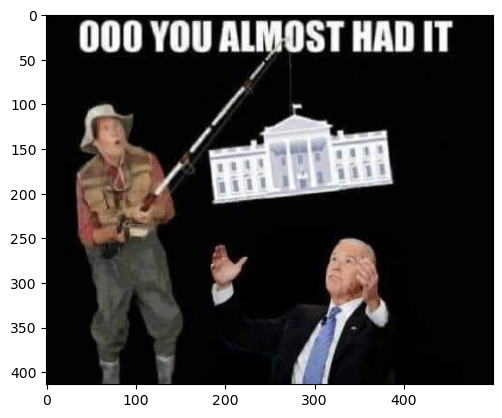

In [26]:
sample = train_missing.sample(1)
plt.imshow(Image.open(sample['image'].values[0]))

print("TEXT: ")
print(sample['text'].values[0])
print("\nLABELS:")
print(sample['labels'].values[0])

Some rows in the DataFrames have empty lists in the labels column, indicating missing labels. After inspecting the original raw data, it appears that some labels were indeed empty from the source dataset, so the issue is not due to the data loading process.

Further investigation of samples with missing labels shows that, even though the content may include relevant techniques, the labels are absent. To ensure that our data is both complete and relevant, we should remove these rows from the DataFrames

In [27]:
train_df = train_df[~train_df.index.isin(train_missing.index)]
test_df = test_df[~test_df.index.isin(test_missing.index)]
dev_df = dev_df[~dev_df.index.isin(dev_missing.index)]

In [28]:
# Check if deleted
len(train_df[train_df['labels'].apply(lambda x: x == [])])

0

### Preprocess 

In the previous sections, we observed significant variation in the structure of the text. For instance, some text is written in all caps, while others are in normal case. In certain instances, text written in all caps includes names, locations, or organizations, which might be challenging for the model to interpret due to the lack of distinction between emphasized and standard text. Therefore, to simplify the task, we will lowercase all texts. Additionally, the text often contains 2 consecutive newline characters `(\n)`, which may carry meaningful context. For example, in the following text:

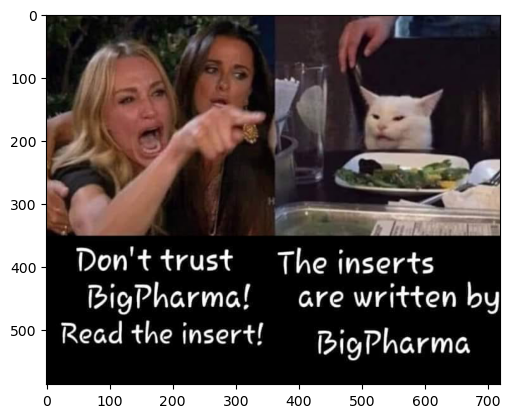

"Don't trust BigPharma!
Read the insert!

The inserts are written by BigPharma"

For this, we will replace "\n\n" with a special token [SEP]. Additionally, some text contains broken English, including misspellings, grammatical errors, or repeated phrases. For example, the text: "Hallo. Ve vill have to restrikt your akkount because you vont konform to kommunity standards" contains several non-standard spellings and grammatical mistakes but itentional, so it may contains some meaning: sarcasm (in this case can be derived from the image).

Additionally, the text contains special characters such as `@` and `?`. These characters may be useful and contain information such as tone that some techniques such as smears may require. Therefore, we won't remove these characters from the text. Finally, the texts have varying lengths, so we will have to add padding (handled by the tokenizer)

Finally, memes often contains words that have different meanings. For example, the following image shows a sheep and a wolf, however, depending on this context, wolf and sheep have different meanings which may not be expressed through the limited text corpus available in the dataset:

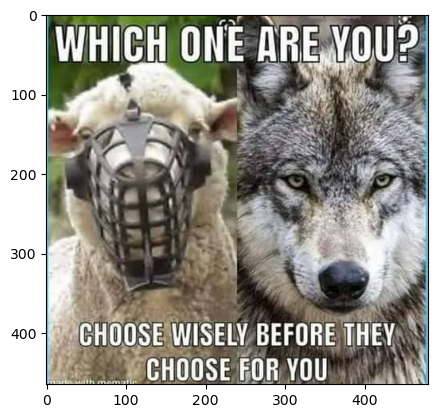

Therefore, it is better to use a pretrained text model on a huge text corpus. Additionally, for the model to be able to detect sheep, and wolf from the image, it needs to have extensive knowledge about different classes, which may not be expressed through this dataset presented labels. Therefore, similarly, it is better to use a pretrained visual model

Converting text to lowercase

In [29]:
# Lower case all texts
train_df['text'] = train_df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()
dev_df['text'] = dev_df['text'].str.lower()
all_df['text'] = all_df['text'].str.lower()

# Replace all new line characters
train_df['text'] = train_df['text'].str.replace('\n\n', '[SEP]')
test_df['text'] = test_df['text'].str.replace('\n\n', '[SEP]')
dev_df['text'] = dev_df['text'].str.replace('\n\n', '[SEP]')
all_df['text'] = all_df['text'].str.replace('\n\n', '[SEP]')

One hot encode the labels

In [30]:
train_df.head()

labels  \
0  [Black-and-white Fallacy/Dictatorship, Name ca...   
1           [Reductio ad hitlerum, Smears, Transfer]   
2  [Appeal to fear/prejudice, Loaded Language, Na...   
3  [Causal Oversimplification, Glittering general...   
4  [Flag-waving, Misrepresentation of Someone's P...   

                                                text  \
0  there are only two genders[SEP]female [SEP]male\n   
1                           this is not an accident!   
2  so bernie bros haven't committed violence eh?[...   
3  pathetic[SEP]the cowardly asshole\nweak failur...   
4  who trump represents[SEP]who democrats represe...   

                                   image  
0  main/training_set_task3/128_image.png  
1  main/training_set_task3/189_image.png  
2   main/training_set_task3/96_image.png  
3  main/training_set_task3/154_image.png  
4   main/training_set_task3/15_image.png

In [31]:
mlb = MultiLabelBinarizer(classes=techniques)

In [32]:
train_df.head()

labels  \
0  [Black-and-white Fallacy/Dictatorship, Name ca...   
1           [Reductio ad hitlerum, Smears, Transfer]   
2  [Appeal to fear/prejudice, Loaded Language, Na...   
3  [Causal Oversimplification, Glittering general...   
4  [Flag-waving, Misrepresentation of Someone's P...   

                                                text  \
0  there are only two genders[SEP]female [SEP]male\n   
1                           this is not an accident!   
2  so bernie bros haven't committed violence eh?[...   
3  pathetic[SEP]the cowardly asshole\nweak failur...   
4  who trump represents[SEP]who democrats represe...   

                                   image  
0  main/training_set_task3/128_image.png  
1  main/training_set_task3/189_image.png  
2   main/training_set_task3/96_image.png  
3  main/training_set_task3/154_image.png  
4   main/training_set_task3/15_image.png

## Setup helper functions

In [33]:
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr  # Keep the initial learning rate for the first 10 epochs
    elif 10 <= epoch < 20:
        return lr * 0.1  # Reduce learning rate by a factor of 10 after epoch 10

In [34]:
# Helper function to redefine callbacks
def get_cbs(cbs=[]):
  res_cbs = []
  for cb in cbs:
    res_cbs.append(cb)

  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_F1_Micro", mode="max")
  res_cbs.append(early_stopping_cb)
  
  return res_cbs

In [35]:
def get_metrics():
    return [
        tfa.metrics.F1Score(num_classes=len(techniques), average='macro', threshold=0.5, name="F1_Macro"),  # Macro F1-score
        tfa.metrics.F1Score(num_classes=len(techniques), average='micro', threshold=0.5, name="F1_Micro"),  # Micro F1-score
    ]

In [36]:
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot loss for Class output
    axs[0, 0].plot(epochs, history.history['F1_Macro'], label='Training Macro F1')
    axs[0, 0].plot(epochs, history.history['val_F1_Macro'], label='Validation Macro F1')
    axs[0, 0].set_title('Training and Validation Macro F1')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Score')
    axs[0, 0].legend()

    # Plot loss for Person output
    axs[0, 1].plot(epochs, history.history['F1_Micro'], label='Training Micro F1')
    axs[0, 1].plot(epochs, history.history['val_F1_Micro'], label='Validation Micro F1')
    axs[0, 1].set_title('Training and Validation Micro F1')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Score')
    axs[0, 1].legend()
    
    # Plot overall loss
    axs[1, 0].plot(epochs, history.history['loss'], label='Training Loss (Overall)')
    axs[1, 0].plot(epochs, history.history['val_loss'], label='Validation Loss (Overall)')
    axs[1, 0].set_title('Training and Validation Loss (Overall)')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    # Remove the fourth subplot (bottom-right corner) if not needed
    fig.delaxes(axs[1, 1])

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [126]:
def multilabel_heatmap(ds, model, threshold=0.5):
    predictions = model.predict(ds, verbose=False)
    true_labels = []
    for _, labels in ds:
        true_labels.append(labels.numpy())

    true_labels = np.concatenate(true_labels, axis=0)  
    pred_labels = (predictions > threshold).astype(int)  

    label_counts = np.sum(true_labels, axis=0)

    conf_matrix = multilabel_confusion_matrix(true_labels, pred_labels)

    num_labels = true_labels.shape[1]

    fig, axs = plt.subplots(6, 4, figsize=(20, 30))

    axs = axs.flatten()

    for i in range(num_labels):
        sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', ax=axs[i])
        axs[i].set_xlabel('Predicted')
        axs[i].set_ylabel('True')
        axs[i].set_title(f'{techniques[i]}: {label_counts[i]}')

    for j in range(num_labels, len(axs)):
        fig.delaxes(axs[j])

    # 0 is absent, 1 is present
    plt.tight_layout()
    plt.show()


In [127]:
def vis_preds(model, ds, threshold=0.5):
    data_batch, label_batch = next(iter(ds))
    image_batch = data_batch[0]
    preds = model.predict(data_batch)
    preds = tf.cast(preds > threshold, dtype=tf.int32)

    plt.figure(figsize=(10, 10))
    for i in range(4):
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy())
        
        print(f"Actual for image {i+1} : {mlb.inverse_transform(np.array([label_batch[i].numpy()]))}")
        print(f"Predicted for image {i+1} : {mlb.inverse_transform(np.array([preds[i].numpy()]))}\n")

In [39]:
def compare_histories(histories, labels):
    # Check that the number of histories matches the number of labels
    assert len(histories) == len(labels), "The number of histories and labels must match."

    # Define metrics to plot
    metrics = ['F1_Macro', 'F1_Micro']
    val_metrics = ['val_F1_Macro', 'val_F1_Micro']

    # Create subplots
    fig, axs = plt.subplots(len(metrics), 1, figsize=(20, 15), sharex=True)
    fig.suptitle('Model Performance Comparison', fontsize=16)

    # Define a color cycle with distinct colors
    colors = cycle(plt.cm.tab10.colors)  # Tab10 colormap provides 10 distinct colors

    for i, metric in enumerate(metrics):
        for j, history in enumerate(histories):
            color = next(colors)
            epochs = range(1, len(history.history[metric]) + 1)
            axs[i].plot(epochs, history.history[metric], label=f'{labels[j]} Training {metric}', color=color)
            axs[i].plot(epochs, history.history[val_metrics[i]], label=f'{labels[j]} Validation {metric}', color=color, linestyle='--')
        axs[i].set_title(metric)
        axs[i].set_ylabel('Value')
        axs[i].legend()

    axs[-1].set_xlabel('Epochs')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust top to make room for the suptitle
    plt.show()

## Approach

### Address data imbalance

In our project, we face a significant challenge with data imbalance, as each sample is associated with multiple labels, rather than a single label. Traditional methods like oversampling or undersampling, often used to balance datasets, become impractical in this scenario due to the complexity introduced by the multi-label nature of the data. Consequently, we turn to an alternative solution: handling the imbalance through the use of a more appropriate loss function.

For this task, we have opted to implement the [Focal Loss](https://arxiv.org/abs/1708.02002) function, as described by Lin et al. in their seminal work on addressing class imbalance in object detection tasks. Unlike binary cross-entropy, which is typically used for multi-label classification, Focal Loss dynamically down-weights the contribution of easy-to-classify examples and focuses more on hard-to-classify instances. This mechanism makes it particularly useful for tasks where a small subset of examples dominate model predictions. In our case, where the dataset is heavily skewed toward a few dominant labels, Focal Loss allows the model to give more attention to the less frequent, harder-to-classify samples. However, while Focal Loss is effective in managing difficult instances, it doesn't directly prioritize minority classes in multi-label classification settings.

Given the extreme imbalance in our data, where the top three labels dominate the distribution, the use of Focal Loss alone may not be sufficient to ensure robust learning across all labels, especially those that appear infrequently. Therefore, in addition to implementing Focal Loss, we plan to fine-tune the threshold for each label during the final model phase. Typically, a default threshold of 0.5 is used to classify an output as positive or negative in multi-label classification. However, this one-size-fits-all approach can lead to suboptimal results in highly imbalanced settings, as it may favor the dominant classes and overlook the minority ones.

By customizing the threshold for each label, we aim to strike a balance between precision and recall, ensuring that the model can more effectively identify minority labels without being biased toward the majority. This approach allows us to tailor the decision boundary for each label, accounting for its relative frequency in the dataset and improving the model’s overall performance, particularly on underrepresented classes.

In summary, through the combined use of Focal Loss and label-specific threshold fine-tuning, we address the challenges of data imbalance in our multi-label classification problem. This strategy ensures that the model can effectively learn from the dominant labels while still paying attention to the minority labels, which are critical to achieving better generalization and improving overall performance.

### Target goals

To evaluate the performance of our models, we have chosen to use both Micro F1 and Macro F1 scores, which are well-suited for multi-label classification tasks, particularly when dealing with imbalanced datasets. These metrics allow us to assess how well the model performs across all labels, including both majority and minority classes, offering a comprehensive view of the model's effectiveness.

In the original competition, the baseline performance using a majority-class prediction model resulted in a Micro F1 score of 0.354 and a Macro F1 score of 0.036. These results reflect the difficulty of the task, especially given the highly imbalanced nature of the dataset. The top-performing model in the competition, which utilized sophisticated techniques and large language models (such as BERT or RoBERTa), achieved significantly better results: a Micro F1 score of 0.581 and a Macro F1 score of 0.273. However, due to resource constraints, it is not feasible for us to implement such large-scale models. Instead, we will set more attainable goals based on our available resources and model constraints.

For the Micro F1 score, which measures the overall performance across all instances and labels by giving equal importance to each instance, we have set a target of 0.45. This is a realistic goal given the resource limitations and the complexity of the task, and it represents a meaningful improvement over the baseline while accounting for the multi-label nature of the dataset.

On the other hand, Macro F1 score evaluates the model's performance on each label individually and then averages these scores, giving equal importance to all labels, regardless of their frequency. This is particularly important for imbalanced datasets, where we want to ensure the model does not neglect minority classes. Given that our dataset is extremely imbalanced, we will aim for a Macro F1 score of 0.1 on the test datasetdue to the severely underrepresented labels

## Baseline

**Overview**
The baseline model employs a dual-branch architecture to process both image and text data separately (the two modalities in our dataset). The features from both branches are then combined to make the final classification decision.

**Model Structure**

- Image Branch:

Features are extracted using a pretrained vision model.

- Text Branch:

Features are extracted using a pretrained language model.
The features from both branches are concatenated to form a unified representation. A dense layer followed by a sigmoid activation is used for classification, as sigmoid is ideal for multi-label tasks, outputting independent probabilities for each label.

- Optimizer:

We chose to use Nadam (Nesterov-accelerated Adaptive Moment Estimation) instead of Adam due to its advantages in convergence speed and handling momentum more efficiently, especially for complex tasks like ours. Given that our model has both text and image branches, which process multi-modal data and rely on large pretrained networks like ALBERT and ResNet50, faster convergence is critical to make the most out of our limited computational resources. Nadam's ability to converge faster and handle optimization efficiently makes it a better choice for our setup, allowing us to reach better performance with fewer training iterations

**Justification for Model Structure**:

Memes often contain complex language and nuanced meanings. Training a language model from scratch on the limited text data from memes is inefficient. Using a pretrained language model, which has been trained on a vast text corpus, allows us to capture the underlying semantics more effectively. Similarly, a pretrained image model, already trained on large datasets, helps identify important visual features, overcoming the limitations of our smaller meme dataset of around 1,000 images. This approach ensures both modalities are processed efficiently and effectively.

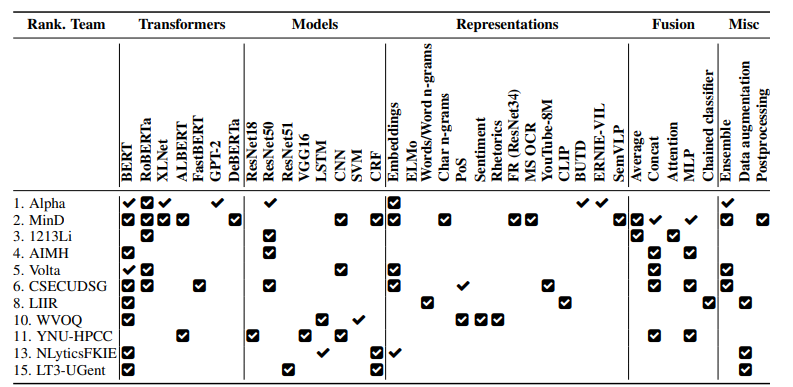

Table 1: Approached used by participating systems

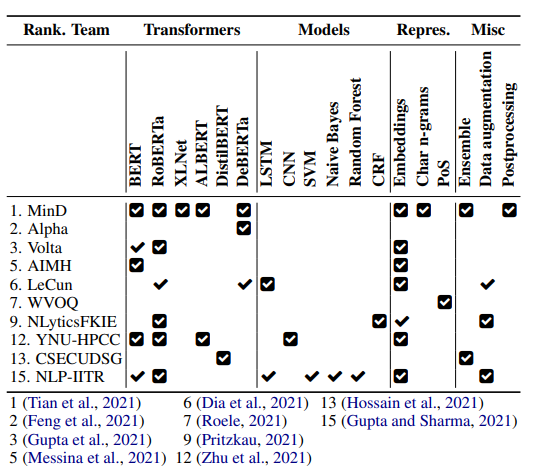

Table 2: Approached used for extracting textual information

In Table 2, the top-performing models for the main task predominantly used transformer-based models like BERT and RoBERTa, which excel at understanding and processing complex text. For our text branch, we will also use a pretrained transformer model to extract meaningful information from the text. However, both BERT and RoBERTa are large models with hundreds of millions of parameters, making them resource-intensive to train, especially on limited computational resources.

To address this, we will use ALBERT (A Lite BERT), a more efficient version of BERT. ALBERT maintains competitive performance by sharing parameters across layers and reducing model size, making it much lighter in terms of computation. This allows us to fine-tune the model on our dataset efficiently, achieving high performance without straining our resources.

In Table 1, the top models for visual tasks frequently employed ResNet50, CNNs, and Conditional Random Fields (CRFs). For our image branch, we will adopt ResNet50, a highly regarded convolutional neural network (CNN) architecture, pretrained on ImageNet. ResNet50 has demonstrated strong performance in a wide range of visual tasks by learning rich features from large-scale image datasets. Using this pretrained model allows us to leverage its learned representations, improving our model's performance on image data while significantly reducing the time and resources required for training from scratch.

By choosing ALBERT for text and ResNet50 for images, we can efficiently handle both modalities while balancing computational efficiency and performance.

#### Load data for Albert

A BERT based tokenizer is needed in the preprocessing step as we use a BERT-based model

In [40]:
albert_model_name = 'albert-large-v2'
albert_tokenizer = AutoTokenizer.from_pretrained(albert_model_name)

# Get the maximum sequence length
lengths = []

for text in train_df['text']:
    lengths.append(len(albert_tokenizer.encode(text, add_special_tokens=False)) + 2)

# Get max length for padding
max_len = max(lengths)

c:\Users\LENOVO\anaconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [41]:
# Function to load images
def load_image(image_path, aug=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    
    if aug:
        image = tf.image.random_flip_left_right(image)
        # Random rotation and brightness, contrast
        image = tf.image.random_brightness(image, 0.5)
        image = tf.image.random_contrast(image, 0.8, 1.3)
    
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image

# Helper function to convert dataframes into datasets
def to_dataset_with_bert(df, tokenizer, shuffle=False, aug=False):
    image_paths = df['image'].values
    texts = df['text'].values
    tokenized_text = tokenizer(texts.tolist(), padding='max_length', truncation=True, 
                               # 2 for the extra [CLS] and [SEP] tokens
                               max_length=max_len, return_tensors='tf') 
    input_ids = tokenized_text['input_ids']
    attention_masks = tokenized_text['attention_mask']
    
    labels = mlb.fit_transform(df['labels'])
    
    dataset = tf.data.Dataset.from_tensor_slices(((image_paths, input_ids, attention_masks), labels))
    
    def process_data(data, label):
        image_path, input_ids, attention_masks = data
        image = load_image(image_path, aug=aug)
        return (image, input_ids, attention_masks), label
    
    dataset = dataset.map(process_data)
    dataset = dataset.shuffle(len(df)) if shuffle else dataset
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

In [42]:
train_ds = to_dataset_with_bert(train_df, tokenizer=albert_tokenizer, shuffle=True)
test_ds = to_dataset_with_bert(test_df, tokenizer=albert_tokenizer)
dev_ds = to_dataset_with_bert(dev_df, tokenizer=albert_tokenizer)

In [43]:
def vis_ds(ds):
    for data, labels in ds.take(1):
        images, input_ids, attention_masks = data
        image, input_id, label = images[0], input_ids[0], labels[0]
        
        plt.imshow(image)
        label_strings = mlb.inverse_transform(np.array([label.numpy()]))
        print(input_id)
        print(label_strings)

tf.Tensor(
[    2    31    92    22    38   985    14  5702    18  1516   182  1750
   187     3   134    15    42    46 12855 11371 17193    20  9454    18
    86     9     9     3     3     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0], shape=(101,), dtype=int32)
[('Smears',)]


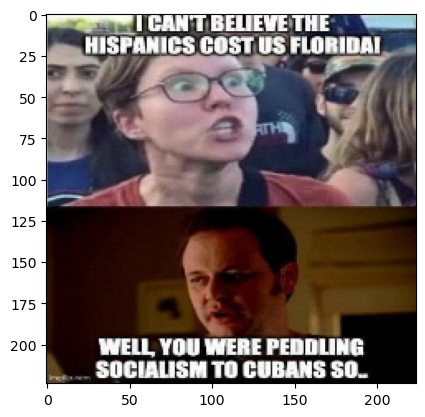

In [44]:
vis_ds(train_ds)

tf.Tensor(
[   2   14 7806   78  740    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(101,), dtype=int32)
[('Name calling/Labeling', 'Slogans', 'Smears', 'Transfer')]


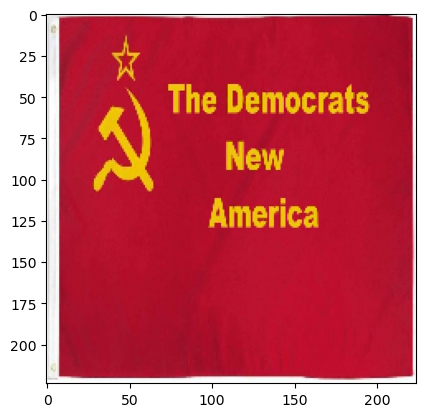

In [45]:
vis_ds(test_ds)

tf.Tensor(
[   2 1637 6416 2483 4458  219   60    3 2247   15   90    9    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(101,), dtype=int32)
[('Doubt', 'Smears')]


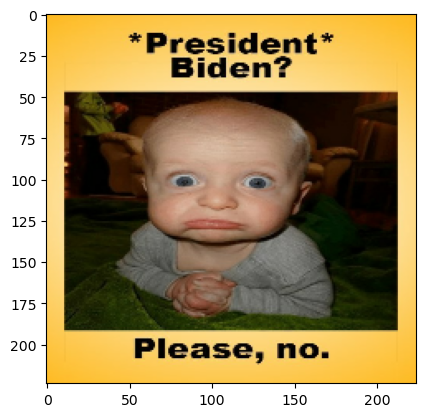

In [46]:
vis_ds(dev_ds)

#### Train model

We will freeze the image extractor (ResNet50) and keep the text extractor (ALBERT) trainable, considering the differences in complexity, computational demands, and the pre-training effectiveness of these models.

ResNet50, when pre-trained on large datasets like ImageNet, learns generalizable features that work well across various tasks, reducing the need for additional fine-tuning. These features are typically robust enough to perform well without further adjustment. On the other hand, while ALBERT is also pre-trained, it often requires fine-tuning to adapt to the specific language and nuances of the task at hand. By fine-tuning only ALBERT, we ensure that the model can better capture the unique text patterns in our dataset while conserving computational resources

In [56]:
def create_baseline():
    # ALBERT Model
    albert_model = TFAutoModel.from_pretrained("albert-large-v2")
    albert_model.trainable = True

    # Define the image branch
    image_extractor = applications.ResNet50V2(include_top=False, weights="imagenet")
    image_extractor.trainable = False
    
    # Image branch
    image_input = layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    x = image_extractor(image_input)
    x = layers.GlobalAveragePooling2D()(x)

    # Text branch
    text_input_ids = layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
    text_attention_mask = layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
    text_embeddings = albert_model(text_input_ids, attention_mask=text_attention_mask)[0]  # Output hidden states
    y = layers.GlobalAveragePooling1D()(text_embeddings)

    # Merge
    combined = layers.Concatenate()([x, y])
    output = layers.Dense(len(techniques), activation='sigmoid')(combined)

    model = models.Model(inputs=[image_input, text_input_ids, text_attention_mask], outputs=output)

    # Compile the model
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-6)
    model.compile(optimizer=optimizer, 
                  loss=losses.BinaryFocalCrossentropy(from_logits=False), metrics=get_metrics())
    
    return (model, albert_model, image_extractor)

In [57]:
baseline, albert_model, image_extractor = create_baseline()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [58]:
baseline_history = baseline.fit(
    train_ds,
    validation_data=dev_ds,
    epochs=100,
    callbacks=get_cbs(), 
    verbose=False,
)

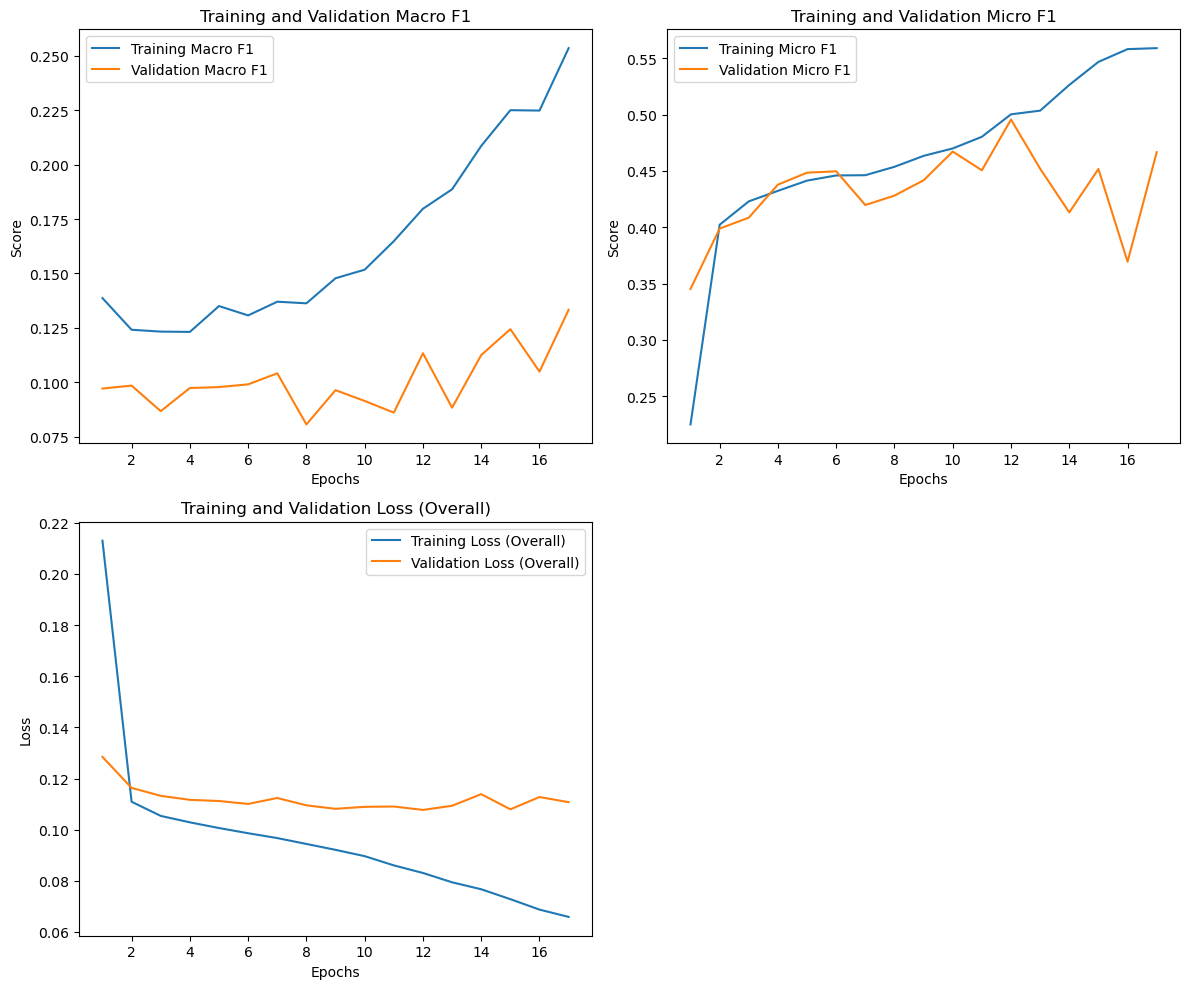

In [59]:
plot_history(baseline_history)

In [60]:
baseline.evaluate(test_ds)

49/49 [==============================] - 4s 80ms/step - loss: 0.1245 - F1_Macro: 0.1291 - F1_Micro: 0.4023


[0.124489426612854, 0.12912899255752563, 0.4023323655128479]

**ANALYSIS**

Using transfer learning, the baseline model achieved a 0.11 macro F1 score and a 0.38 micro F1 score on the test dataset. However, when looking at the training history, it's clear that both the macro and micro F1 scores plateau around 0.1 and 0.4 on the validation set. Additionally, the model is overfitting, as indicated by the loss and accuracy graphs.

The reason the model struggles to exceed a 40% micro F1 score could be that it's not learning how the two types of data (text and image) interact with each other. Understanding memes requires spatial cues as with words only, the context can be drastically different. Therefore, the model needs to learn how to connect and compare information from both text and images data. Currently, the baseline model is only concatenating the extracted features of 2 modalities, and then followed by the output head. In this approach, the model is not learning any iterations between the 2 features, therefore, we need a different fusion mechanism for the model to learn the iteractions between 2 modalities.

For this, I suggest implementing a Dual Transformer model inspired by [this paper](https://aclanthology.org/2021.semeval-1.140.pdf) with some modifications to suit our target and capability. Specifically, in our approach, the model will be able learn important features in each modalities, then learn the iteractions between the important features in each modallity. For this, we will train transformers on the extracted features. As each modality has distinct features, so assigning a dedicated transformer to each ensures that the model learns these unique patterns thoroughly using self-attention. Additionally, cross-attention mechanism allows the model to enrich one modality’s features based on the other modality. 

Depending on the target and query input to tranformer, contextualized feature (features that were enriched by the other modality) can be extracted. However, since there 2 modalities, we can get 2 contextualized features: image enriched by text, and text enriched by image. The two modalities can offer complementary interpretations, which might not always be aligned. For instance, the text might suggest one thing, while the image may convey something subtly different. Therefore, we will add separate output heads for both "text enriched by image" and "image enriched by text", the model can learn separate but related interpretations of the meme’s meaning. This way, the model can make predictions that account for both modalities’ influence

Additionally, since transformers are notorious for overfitting, especially in the case where there are not alot of data to train, we will apply regularization techniques directly inside the Transformer implementation. Additionally, adding output heads for each modality and averaging the probabilities can also serve as an implicit form of regularization. Instead of relying on a single set of features that could lead to overfitting, then model is making the final decision based on multiple perspectives

## Dual Transformer 

### Transformer implementation as Layer

First, we need to implement a custom Transformer layer in TensorFlow, as TensorFlow's built-in layers do not offer this layer out of the box. This custom layer will not include positional embeddings or attention masks, giving us more control. When using the layer, these components—positional embeddings and attention masks—must be generated and applied externally.

To prevent overfitting, and optimize, we will apply regularization techniques, such as L2 regularization

In [2]:
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate):
        super().__init__()
        self.attn = layers.MultiHeadAttention(num_heads=n_heads, key_dim=d_model, dropout=dropout_rate)
        self.layer_norm_1 = layers.LayerNormalization()
        self.add_1 = layers.Add()
        self.ff = tf.keras.Sequential([
            layers.Dense(dff, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            layers.Dropout(dropout_rate),
        ])
        self.add_2 = layers.Add()
        self.layer_norm_2 = layers.LayerNormalization()
        
    def call(self, Z, attention_mask=None):
        skip = Z
        Z = self.attn(Z, value=Z, attention_mask=attention_mask)
        Z = self.layer_norm_1(self.add_1([Z, skip]))
        
        skip = Z
        
        Z = self.ff(Z)
        Z = self.layer_norm_2(self.add_2([Z, skip]))
        return Z

In [3]:
class TransformerEncoder(layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate, N=2):
        super().__init__()
        self.encoders = [EncoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(N)]
    
    def call(self, Z, attention_mask=None):
        for encoder in self.encoders:
            Z = encoder(Z, attention_mask=attention_mask)
        return Z

In [4]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate=0.1):
        super().__init__()
        
        self.self_attn = layers.MultiHeadAttention(num_heads=n_heads, key_dim=d_model, dropout=dropout_rate)
        self.layer_norm_1 = layers.LayerNormalization()
        self.add_1 = layers.Add()
        
        self.cross_attn = layers.MultiHeadAttention(num_heads=n_heads, key_dim=d_model, dropout=dropout_rate)
        self.layer_norm_2 = layers.LayerNormalization()
        self.add_2 = layers.Add()
        
        self.ff = tf.keras.Sequential([
            layers.Dense(dff, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            layers.Dropout(dropout_rate),
        ])
        self.layer_norm_3 = layers.LayerNormalization()
        self.add_3 = layers.Add()
        
    def call(self, Z, encoder_outputs, casual_mask=None, decoder_pad_mask=None, encoder_pad_mask=None):
        # Z here is decoder_in
        skip = Z
        if casual_mask == None:
            Z = self.self_attn(Z, value=Z, attention_mask=decoder_pad_mask) 
        else:
            Z = self.self_attn(Z, value=Z, attention_mask=casual_mask & decoder_pad_mask)
        Z = self.layer_norm_1(self.add_1([Z, skip]))
        
        # Second multihead attention block
        skip = Z
        Z = self.cross_attn(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
        Z = self.layer_norm_2(self.add_2([Z, skip]))
        
        # Feed forward layers
        skip = Z
        Z = self.ff(Z)
        Z = self.layer_norm_3(self.add_3([Z, skip]))
        
        return Z

In [5]:
class TransformerDecoder(layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate, N=2):
        super().__init__()
        self.decoders = [DecoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(N)]
        
    def call(self, Z, encoder_outputs, casual_mask=None, decoder_pad_mask=None, encoder_pad_mask=None):
        for decoder in self.decoders:
            Z = decoder(Z, encoder_outputs, casual_mask=casual_mask, decoder_pad_mask=decoder_pad_mask, encoder_pad_mask=encoder_pad_mask)
        return Z

In [6]:
class Transformer(layers.Layer):
    def __init__(self, d_model, dff, n_heads=4, dropout_rate=0.1, N_encoders=2, N_decoders=2):
        super().__init__()
        self.encoder = TransformerEncoder(d_model, n_heads, dff, dropout_rate, N=N_encoders)
        self.decoder = TransformerDecoder(d_model, n_heads, dff, dropout_rate, N=N_decoders)
    
    def call(self, encoder_in, decoder_in, encoder_pad_mask=None, decoder_pad_mask=None, casual_mask=None):
        Z = encoder_in
        Z = self.encoder(Z, attention_mask=encoder_pad_mask)
        
        encoder_outputs = Z
        Z = decoder_in
        Z = self.decoder(Z, encoder_outputs, casual_mask=casual_mask, decoder_pad_mask=decoder_pad_mask, encoder_pad_mask=encoder_pad_mask)
        return Z
    

Example usage:

transformer = Transformer(d_model=embed_size, dff=n_units)

Z = transformer(encoder_in, decoder_in, encoder_pad_mask=encoder_pad_mask, decoder_pad_mask=decoder_pad_mask, casual_mask=casual_mask)

### Dual Transformer model

#### Define layers

In [7]:
class ImageEncoder(layers.Layer):
    def __init__(self, model=None, pool_size=(7, 7)):
        super(ImageEncoder, self).__init__()
        # Use ResNet50 because of limited computation power
        if model == None:
            self.cnn = applications.ResNet50V2(include_top=False, weights="imagenet")
            self.cnn.trainable = False
        else:
            self.cnn = model
        self.spatial_feats_dim = self.cnn.output_shape[-1]
        self.avg_pool = tfa.layers.AdaptiveAveragePooling2D(output_size=pool_size)

        
    def call(self, image):
        spatial_feats = self.cnn(image)
        spatial_feats = self.avg_pool(spatial_feats)
        return spatial_feats # (batch size, 7, 7, 2048) or (batch size, 2048, 7, 7) in pytorch

In [8]:
class TextEncoderAlbert(layers.Layer):
    def __init__(self, trainable=True, large=True, model=None):
        super(TextEncoderAlbert, self).__init__()
        # Use albert-large-v2 by default
        if large:
            name = "albert-large-v2"
        else:
            name = "albert-base-v2"
        
        if model == None:
            config = AlbertConfig.from_pretrained(name, 
                                                output_hidden_states=True)
            self.model = TFAutoModel.from_pretrained(name, config=config)
            self.model.trainable = trainable
        else:
            self.model = model
        
    def call(self, input_ids, attn_masks):
        outputs = self.model(input_ids, attention_mask=attn_masks)
        last_hidden_states = outputs.hidden_states[-1]
        return last_hidden_states # (B, max_len, hidden_size)
        

In [9]:
class ImageGridPositionEncoding(layers.Layer):
    def __init__(self, d_model, n_regions=(4, 4)):
        super().__init__()
        assert n_regions[0] == n_regions[1]
        self.n_regions = n_regions
        self.coord_tensor = self.build_coord_tensor(n_regions[0])
        self.proj_embds = layers.Dense(d_model)
        
    @staticmethod
    def build_coord_tensor(d):
        coords = np.linspace(-1., 1., d)
        x = np.tile(coords, (d, 1))
        y = np.tile(coords.reshape(d, 1), (1, d))
        ct = np.stack((x, y), axis=-1)  # Shape (d, d, 2)
        return tf.convert_to_tensor(ct, dtype=tf.float32)
    
    def call(self, x, start_token=False):
        assert not (start_token and self.n_regions[0] == tf.sqrt(tf.cast(tf.shape(x)[0], tf.float32)))
        
        bs = tf.shape(x)[0]
        ct = tf.reshape(self.coord_tensor, (self.n_regions[0] ** 2, -1))  # Shape (16, 2)
        
        ct = self.proj_embds(ct)  # Shape (16, d_model)
        ct = tf.expand_dims(ct, axis=0) # Shape (1, 16, d_model)
        
        x += tf.repeat(ct, repeats=bs, axis=0) 
            
        return x

In [10]:
class DualTransformer(layers.Layer):
    def __init__(self, embd_dim, ff_dim, n_heads=4, n_encoders=4, n_decoders=4, vis_feats_dim=2048, grid=(7, 7), dropout_rate=0.1):
        super().__init__()
        
        self.text_on_image_transformer = Transformer(d_model=embd_dim, n_heads=n_heads, dff=ff_dim, dropout_rate=dropout_rate, 
                                                     N_encoders=n_encoders, N_decoders=n_decoders)
        self.image_on_text_transformer = Transformer(d_model=embd_dim, n_heads=n_heads, dff=ff_dim, dropout_rate=dropout_rate,
                                                     N_encoders=n_encoders, N_decoders=n_decoders)
        
        self.text_proj = layers.Dense(embd_dim)
        self.image_proj = layers.Dense(embd_dim)
        
        self.pos_encoder = ImageGridPositionEncoding(vis_feats_dim, grid)
    
    def call(self, text, attn_masks, image):
        # text is textual features, image is spatial features
        bs = tf.shape(text)[0]
        
        # text already is shape B, S, D
        text = self.text_proj(text) # Map to common representation space

        image = tf.reshape(image, (bs, tf.shape(image)[1]**2, tf.shape(image)[-1]))
        
        # Augment visual features with positional encoding and map them to common representation space
        image = self.pos_encoder(image)  
        image = self.image_proj(image)
        
        # Convert mask to boolean 
        attn_masks = tf.cast(attn_masks, dtype=tf.bool)
        attn_masks = tf.expand_dims(attn_masks, axis=1)

        # Image transformer conditioned on text
        image_out = self.image_on_text_transformer(text, image, encoder_pad_mask=attn_masks)

        # Text transformer conditioned on image
        text_out = self.text_on_image_transformer(image, text, decoder_pad_mask=attn_masks)
        
        return image_out, text_out

In [11]:
class MemeClassifier(models.Model):
    def __init__(self, embd_dim=1024, ff_dim=1024, n_heads=4, n_encoders=4, n_decoders=4, vis_feats_dim=2048, 
                 grid=(7, 7), dropout_rate=0.1, text_model_trainable=True,
                 large=True, vision_model=None, text_model=None):
        super().__init__()
        
        self.visual_module = ImageEncoder(pool_size=grid, model=vision_model)
        self.textual_module = TextEncoderAlbert(trainable=text_model_trainable, large=large, model=text_model)
        
        self.processing_module = DualTransformer(embd_dim, ff_dim, n_heads=n_heads, n_encoders=n_encoders, n_decoders=n_decoders, 
                                                 vis_feats_dim=vis_feats_dim, grid=grid, dropout_rate=dropout_rate)
        self.text_class_head = layers.Dense(22, activation="sigmoid")
        self.image_class_head = layers.Dense(22, activation="sigmoid")

    def call(self, inputs):
        image, input_ids, attn_masks = inputs
        
        image_feats = self.visual_module(image)
        text_feats = self.textual_module(input_ids, attn_masks)
        
        image_out, text_out = self.processing_module(text_feats, attn_masks, image_feats)
        
        image_probs = self.image_class_head(image_out[:, 0, :])
        text_probs = self.text_class_head(text_out[:, 0, :])
        
        return (image_probs + text_probs) / 2

#### Train

**EMBEDDING DIMENSION AND FEEDFORWARD DIMENSION**

Given our limited computational power and memory, we have chosen to set both the embedding dimension and feedforward dimension to 128. This smaller size reduces training time and helps the model generalize better by limiting its capacity to memorize patterns, thereby reducing overfitting. In earlier experiments (not included in this notebook), we tested larger dimensions such as 256 and 512, but found that these configurations often led to overfitting. As a result, we will stick with 128 to maintain a balance between model complexity and performance.

**LOSS FUNCTION**

Initially, we will use Binary Cross-Entropy (BCE) as the loss function to gauge the model's performance. However, if the Macro F1 score fails to improve or starts decreasing, we plan to switch to Focal Loss. Since our dataset is highly imbalanced, focusing on improving the Micro F1 score can lead to a drop in the Macro F1 score—meaning the model becomes better at predicting the majority classes but struggles with the minority ones. To mitigate this, we will incorporate label smoothing into the loss function, using a smoothing value of 0.1.

The reasons for selecting a smoothing value of 0.1 include:

- The baseline model showed signs of overfitting.
- We are fine-tuning ALBERT, which benefits from regularization techniques like label smoothing.
- A smoothing value of 0.1 is widely used in Transformer models to balance performance and regularization.
- The dataset is highly imbalanced, and label smoothing helps the model avoid becoming too confident in its predictions, which can improve generalization, particularly on the minority classes.

By using 128 dimensions and label smoothing, we aim to prevent overfitting, enhance the model's robustness, and ensure that both majority and minority classes are treated fairly during training.

In [56]:
model = MemeClassifier(embd_dim=128, ff_dim=128,)

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000005)
model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1),
              metrics=get_metrics())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


A learning rate scheduler is used to further squeeze out performance in the last few epochs.

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
history = model.fit(train_ds, validation_data=dev_ds, epochs=20, callbacks=get_cbs([lr_scheduler]), verbose=False)

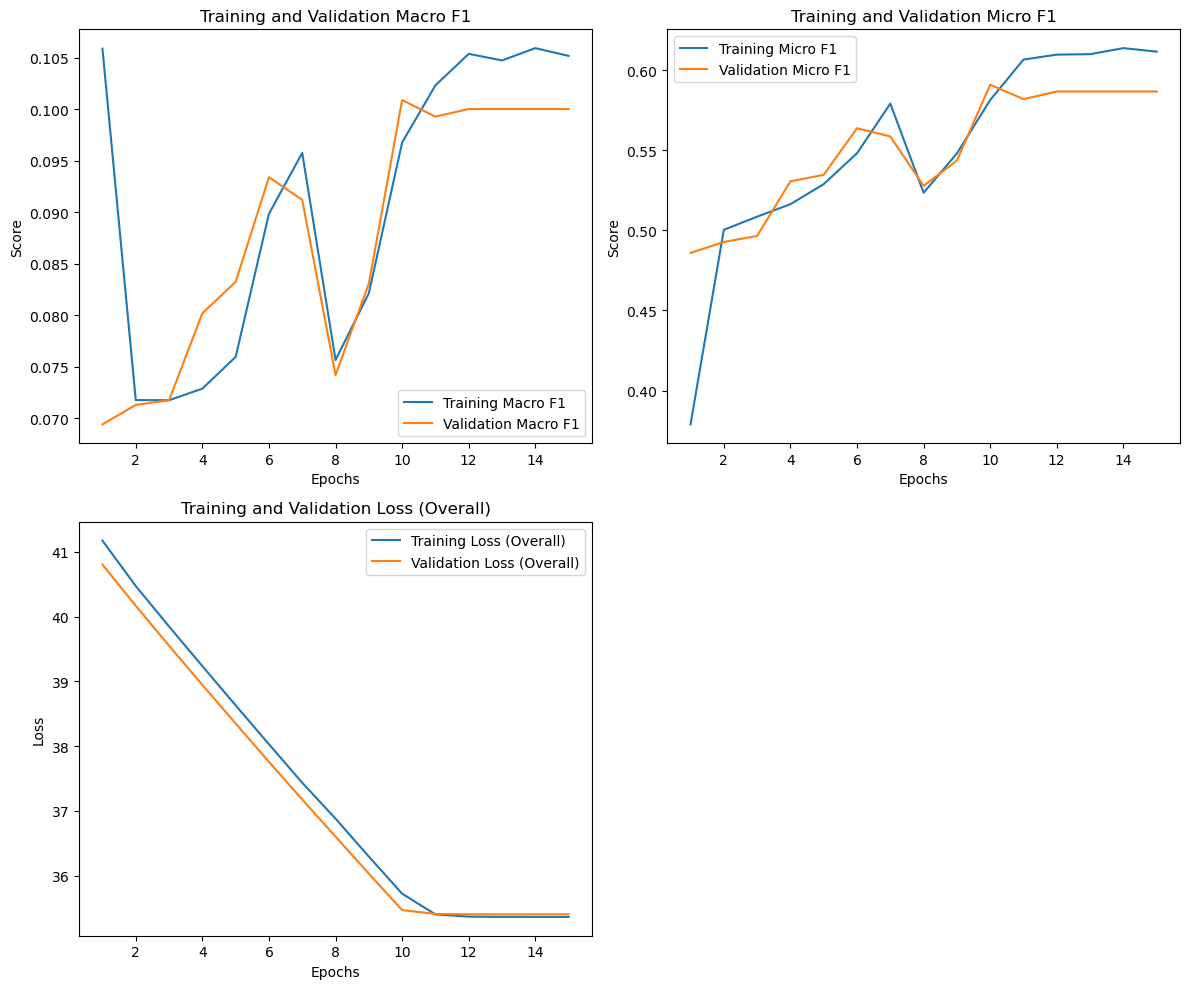

In [58]:
plot_history(history)

#### Evaluate

In [59]:
model.evaluate(test_ds)

49/49 [==============================] - 8s 152ms/step - loss: 35.4787 - F1_Macro: 0.0915 - F1_Micro: 0.5022


[35.47874069213867, 0.09154251217842102, 0.5022221803665161]

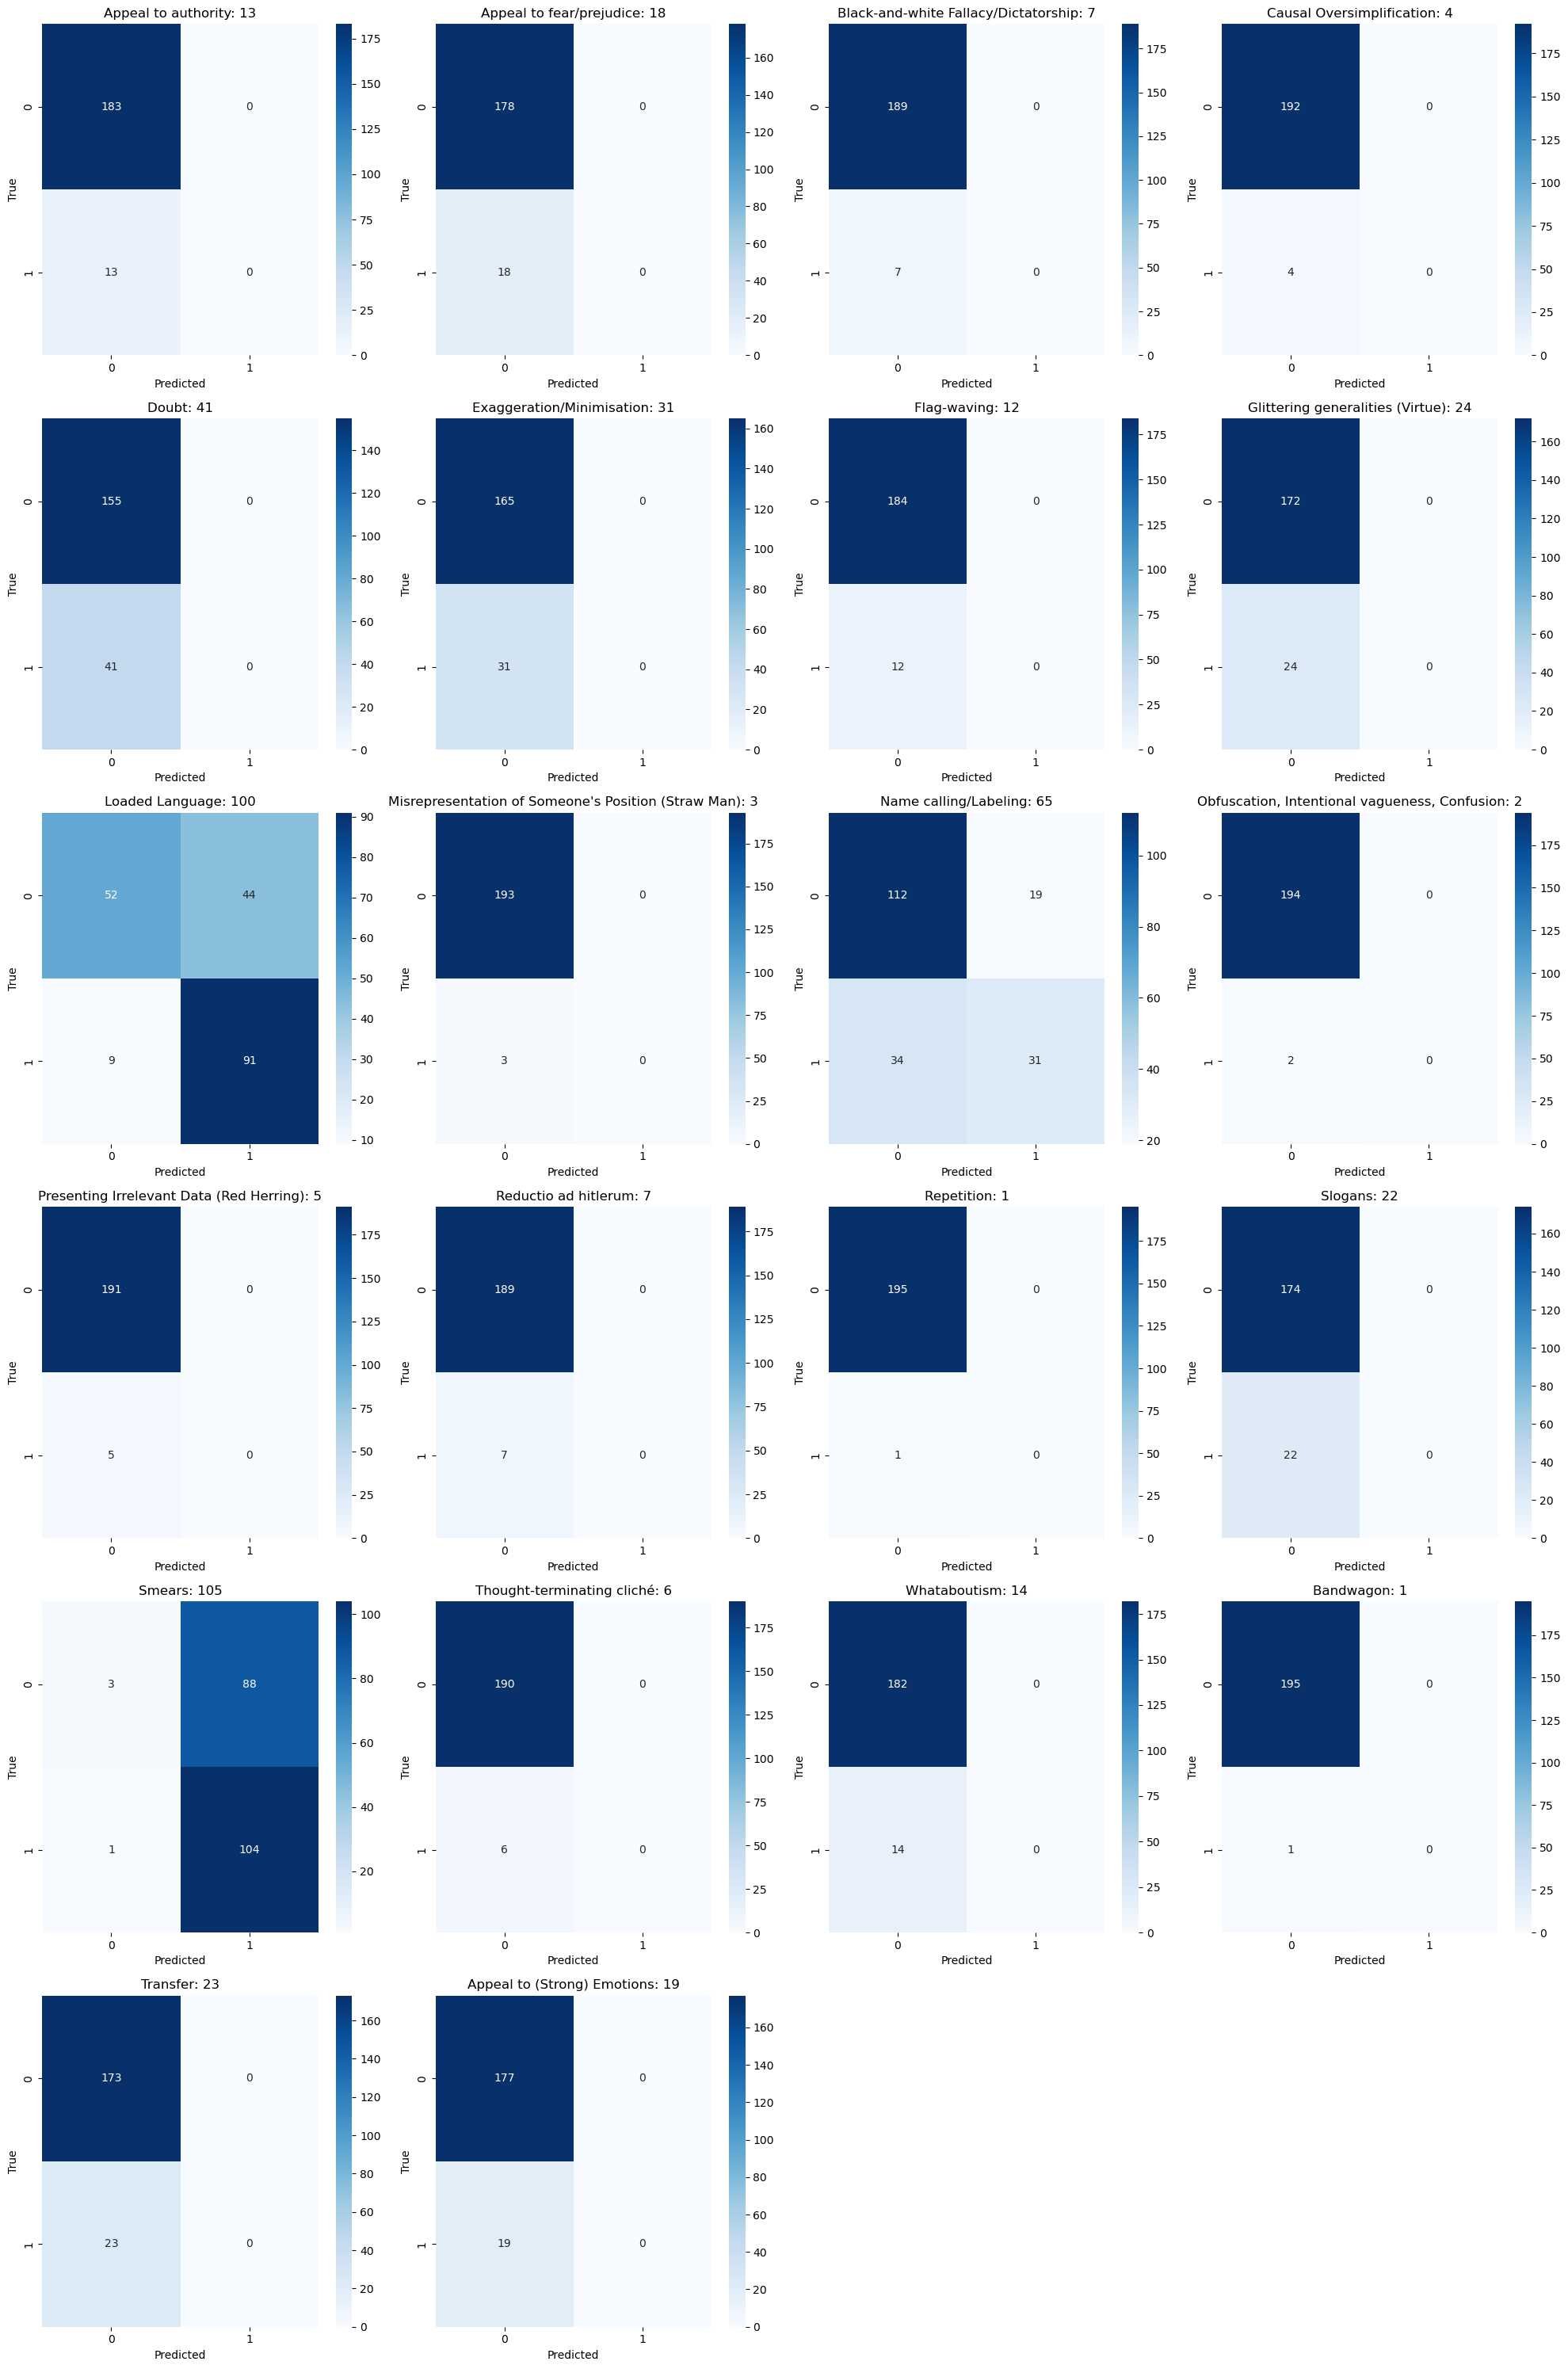

In [60]:
multilabel_heatmap(test_ds, model)

**ANALYSIS**

The new model has shown notable improvements, particularly in avoiding overfitting, as evident from the loss curve. This suggests that our approach has been effective. Moreover, the model achieved a substantial boost in the Micro F1 score, improving from 0.38 (baseline) to 0.5. However, this improvement comes with a trade-off: the Macro F1 score saw a 3% drop.

**TRADEOFF**

Upon reviewing the heatmap, it’s clear that the model continues to struggle with minority classes. For instance, it made no correct predictions for the "Bandwagon" class, highlighting that while the model performs well for majority classes, it still fails to address the minority ones effectively. This indicates the model is overly confident in predicting majority classes and tends to neglect the smaller ones—an undesirable outcome in our task.

While it was somewhat expected for the model to struggle with extremely small classes like "Bandwagon," which has fewer than 10 samples in the training set, it’s surprising that it also failed to predict the larger "Doubt" class, which has 41 samples. This suggests a significant bias toward majority classes, hindering its ability to generalize to minority classes effectively.

**NEXT STEP**

Since the model is no longer overfitting, we won't regularize the model. Therefore, our next objective is to improve the Macro F1 score by ensuring the model pays more attention to minority classes while maintaining its strong performance on majority classes. To achieve this, we will implement Focal Loss, a loss function designed to assign greater importance to harder-to-classify instances, like those from minority classes. By using Focal Loss, we hope to encourage the model to learn these underrepresented classes better and make more accurate predictions, thereby improving overall performance on minority labels.

#### Focal Loss

In [56]:
model = MemeClassifier(embd_dim=128, ff_dim=128,)

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000005)
model.compile(optimizer=optimizer, loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1),
              metrics=get_metrics())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [57]:
history = model.fit(train_ds, validation_data=dev_ds, epochs=20, callbacks=get_cbs([lr_scheduler]), verbose=False)

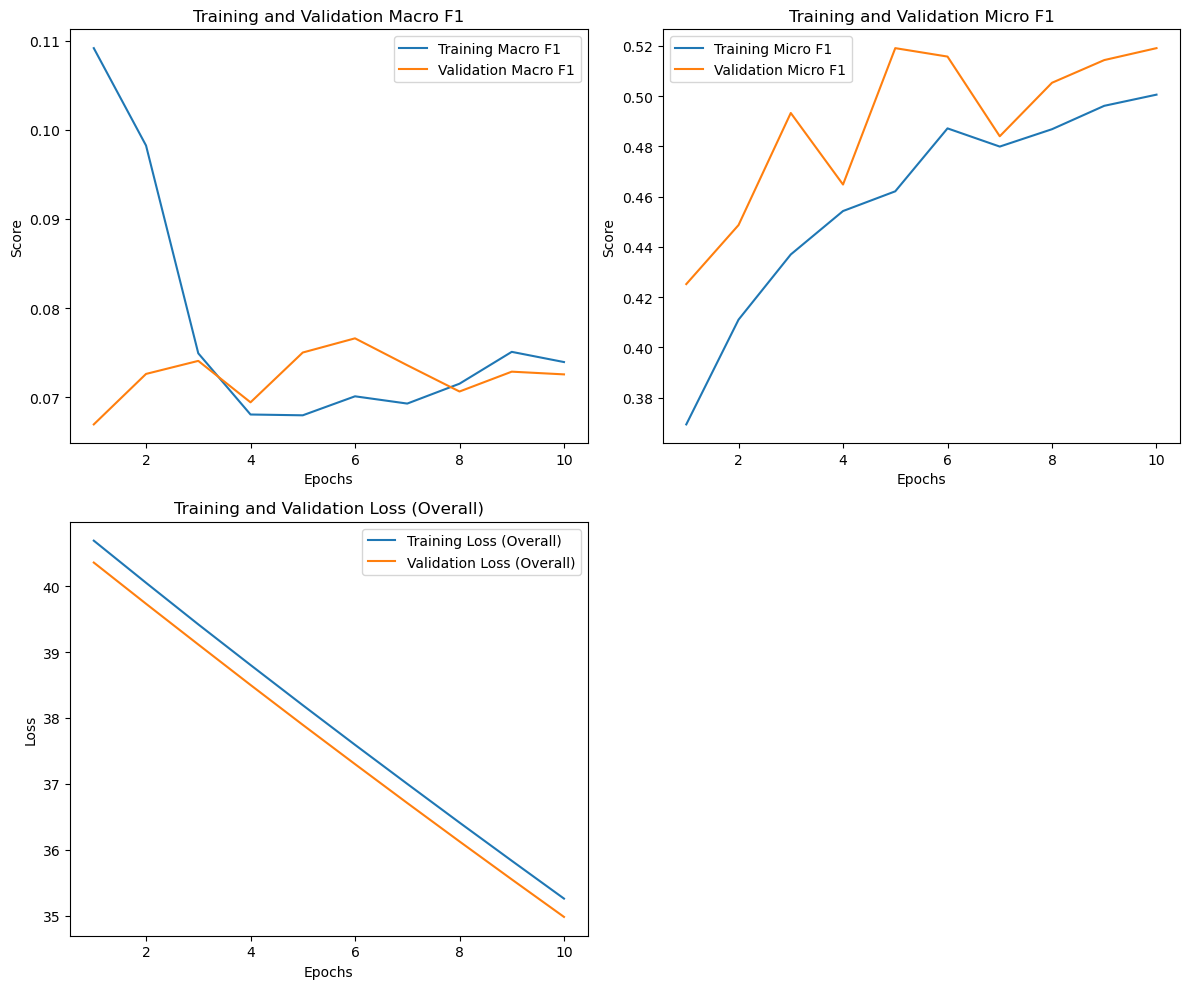

In [58]:
plot_history(history)

In [59]:
model.evaluate(test_ds)

49/49 [==============================] - 5s 111ms/step - loss: 37.9009 - F1_Macro: 0.0625 - F1_Micro: 0.4334


[37.90085220336914, 0.06246054172515869, 0.43337199091911316]

**OBSERVATION**

Interestingly, using Focal Loss combined with label smoothing resulted in an even lower Macro F1 score compared to Binary Cross-Entropy (BCE). Additionally, the Micro F1 score also dropped significantly. This likely occurs because Focal Loss emphasizes hard-to-classify examples, but these examples aren’t always the minority classes. As a result, the model may overlook minority classes during training if they aren’t consistently treated as "hard" examples.

Given these findings, we have decided to switch back to Binary Cross-Entropy (BCE) as our loss function instead of Focal Loss. Moving forward, to try to increase the model's performance, we will focus on hyperparameter tuning, particularly threshold tuning and fine-tuning.

## Fine tuning

In this section, the following strategy, which is different from the approach used for the baseline model will be taken:
* Phase 1: Freeze both ALBERT and ResNet50
    - Initially, freeze both models, and train only the task-specific layers (classification heads).
    - This allows the model to first learn how to combine the information extracted from both pre-trained models without modifying the pre-trained layers

* Phase 2: Unfreeze ALBERT first
    - Unfreeze and train model with ALBERT while keeping ResNet50 frozen
    - This step allows us to fine-tune the text processing part of the model without disrupting the image feature extraction from ResNet50

* Phase 3: Freeze ALBERT and unfreeze ResNet50 gradually
    - Freeze ALBERT and start gradually unfreezing and fine-tuning ResNet50
    - This will allow the image extraction layers to be fine-tuned to our dataset while ensuring that the text features (from ALBERT) remain unchanged

* Phase 4: Unfreeze both ALBERT and ResNet50
    - Unfreeze both ALBERT and ResNet50 for fine-tuning the full model
    - This final stage ensures that both components are able to adapt to each other and ourr dataset, providing potentially better overall performance

**AIM** 

This progressive unfreezing approach helps maintain the stability of the model while gradually fine-tuning each component to the specific data. By starting with frozen pretrained layers, we avoid overwhelming the model and ensure that the task-specific layers can learn to integrate text and image features first. Unfreezing ALBERT and ResNet50 separately allows each branch to specialize before being fine-tuned together, resulting in a more balanced and optimized model. This step-by-step approach also helps mitigate the risk of overfitting or destabilizing pretrained layers, which is critical when working with limited data

#### Phase 1

In [58]:
# Define and freeze pretrained models
config = AlbertConfig.from_pretrained("albert-large-v2", output_hidden_states=True)
albert = TFAutoModel.from_pretrained("albert-large-v2", config=config)
albert.trainable = False

resnet50 = applications.ResNet50V2(weights="imagenet", include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
resnet50.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
model = MemeClassifier(embd_dim=128, ff_dim=128, text_model=albert, vision_model=resnet50) 

loss_fn = losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1)
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=get_metrics())

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
cbs = get_cbs([lr_scheduler])

history = model.fit(train_ds, validation_data=dev_ds, epochs=20, callbacks=cbs, verbose=False)

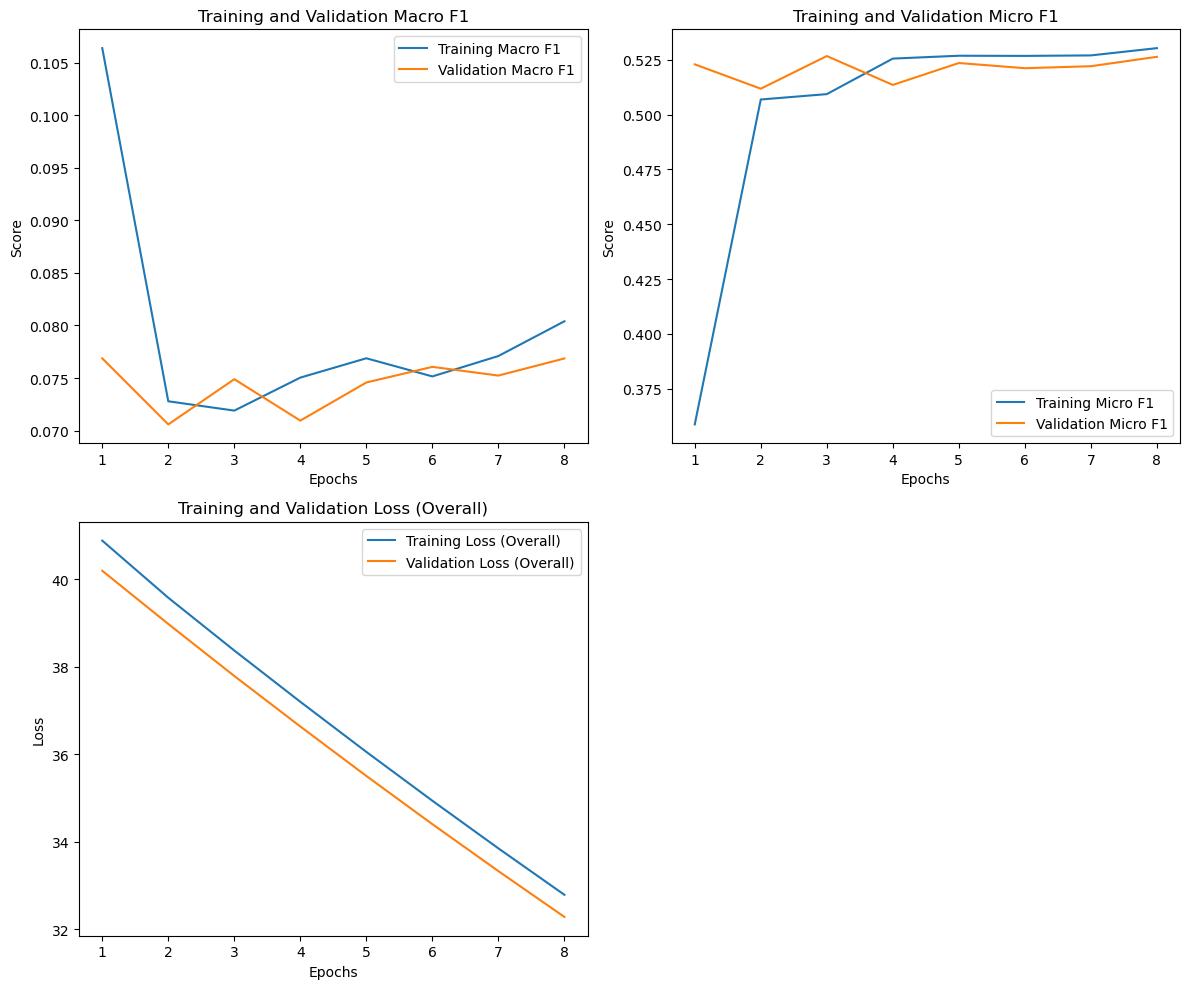

In [60]:
plot_history(history)

The model is not overfitting, however, model's validation f1 score seems to stuck around 0.5 and 0.07 for macro and micro f1 score respetively. 

#### Phase 2

In [ ]:
albert.trainable = True

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=get_metrics())

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
cbs = get_cbs([lr_scheduler])

history = model.fit(train_ds, validation_data=dev_ds, epochs=20, callbacks=cbs, verbose=False)

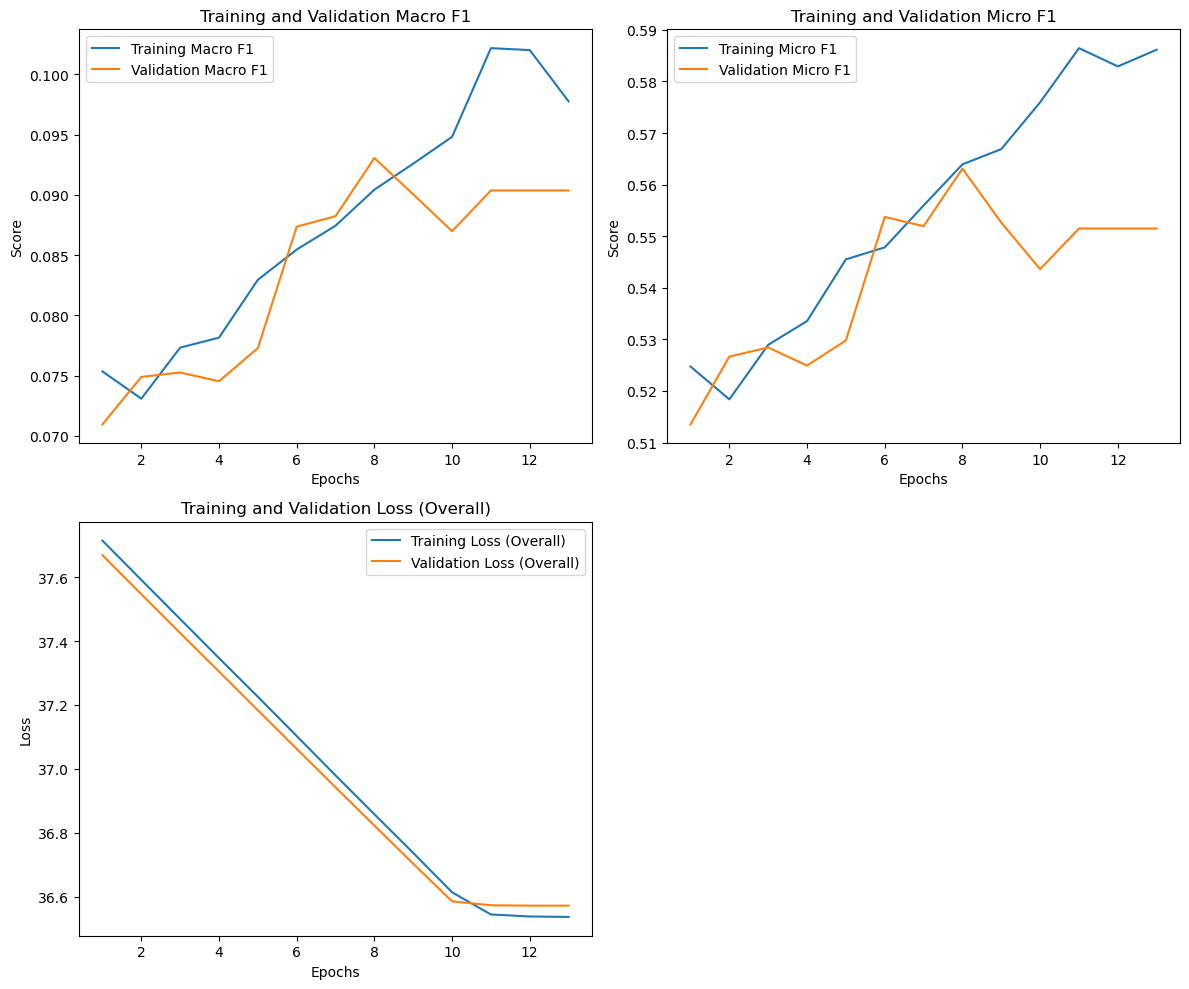

In [63]:
plot_history(history)

#### Phase 3

In [65]:
# Freeze albert
albert.trainable = False

In [66]:
# Unfreeze ResNet50 gradually
for layer in resnet50.layers[-10:]: # Number of layers in stage 5    
    layer.trainable = True

In [ ]:
# Retrain model
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000001)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=get_metrics())

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
cbs = get_cbs([lr_scheduler])

history = model.fit(train_ds, validation_data=dev_ds, epochs=20, callbacks=cbs, verbose=False)

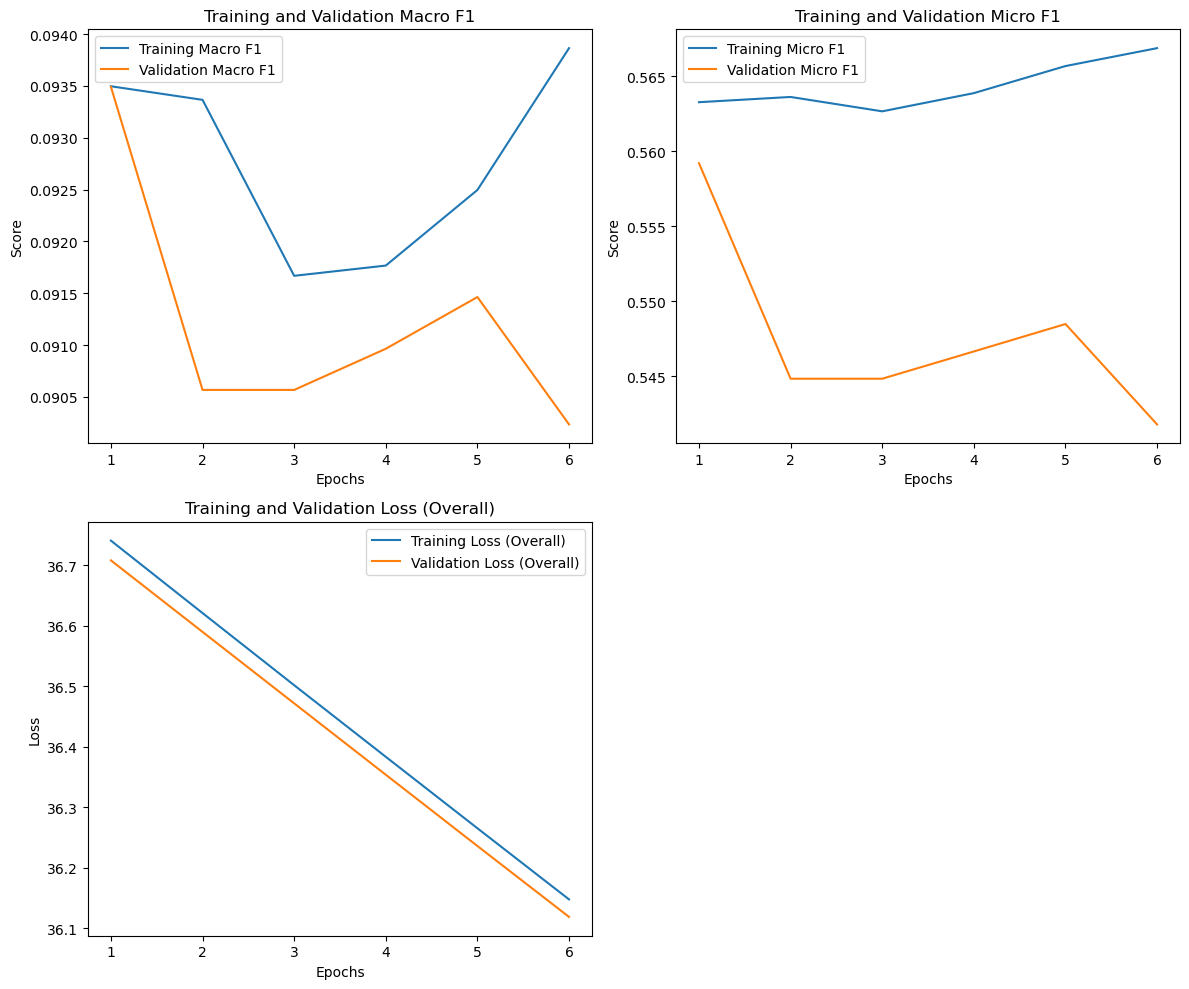

In [69]:
plot_history(history)

In [71]:
# Unfreeze stage 4
for layer in resnet50.layers[-20:]: 
    layer.trainable = True

In [ ]:
# Retrain model
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000001)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=get_metrics())

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
cbs = get_cbs([lr_scheduler])

history = model.fit(train_ds, validation_data=dev_ds, epochs=20, callbacks=cbs, verbose=False)

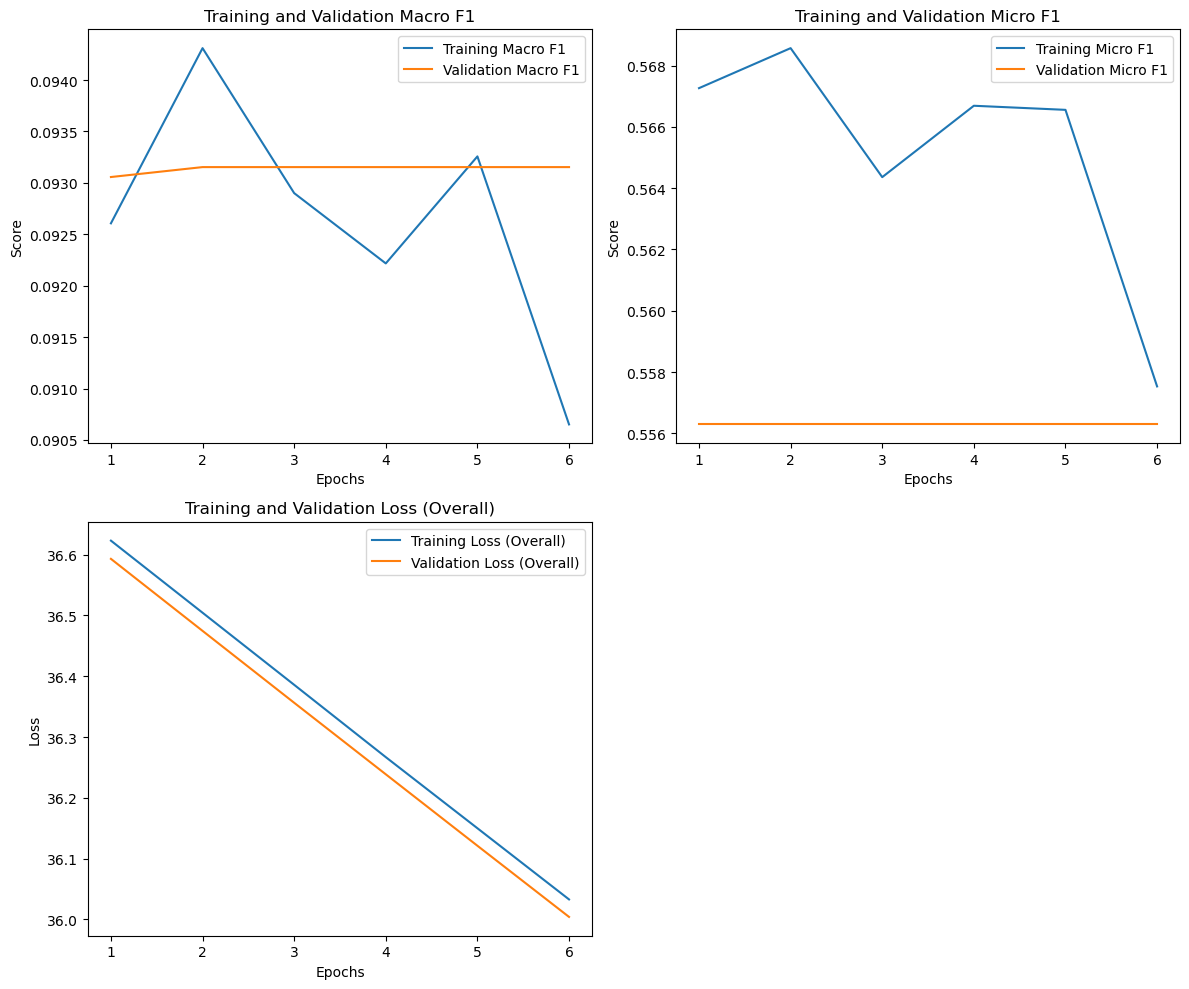

In [73]:
plot_history(history)

#### Phase 4

In [75]:
albert.trainable = True

In [ ]:
# Retrain model
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000001)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=get_metrics())

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
cbs = get_cbs([lr_scheduler])

history = model.fit(train_ds, validation_data=dev_ds, epochs=20, callbacks=cbs, verbose=False)

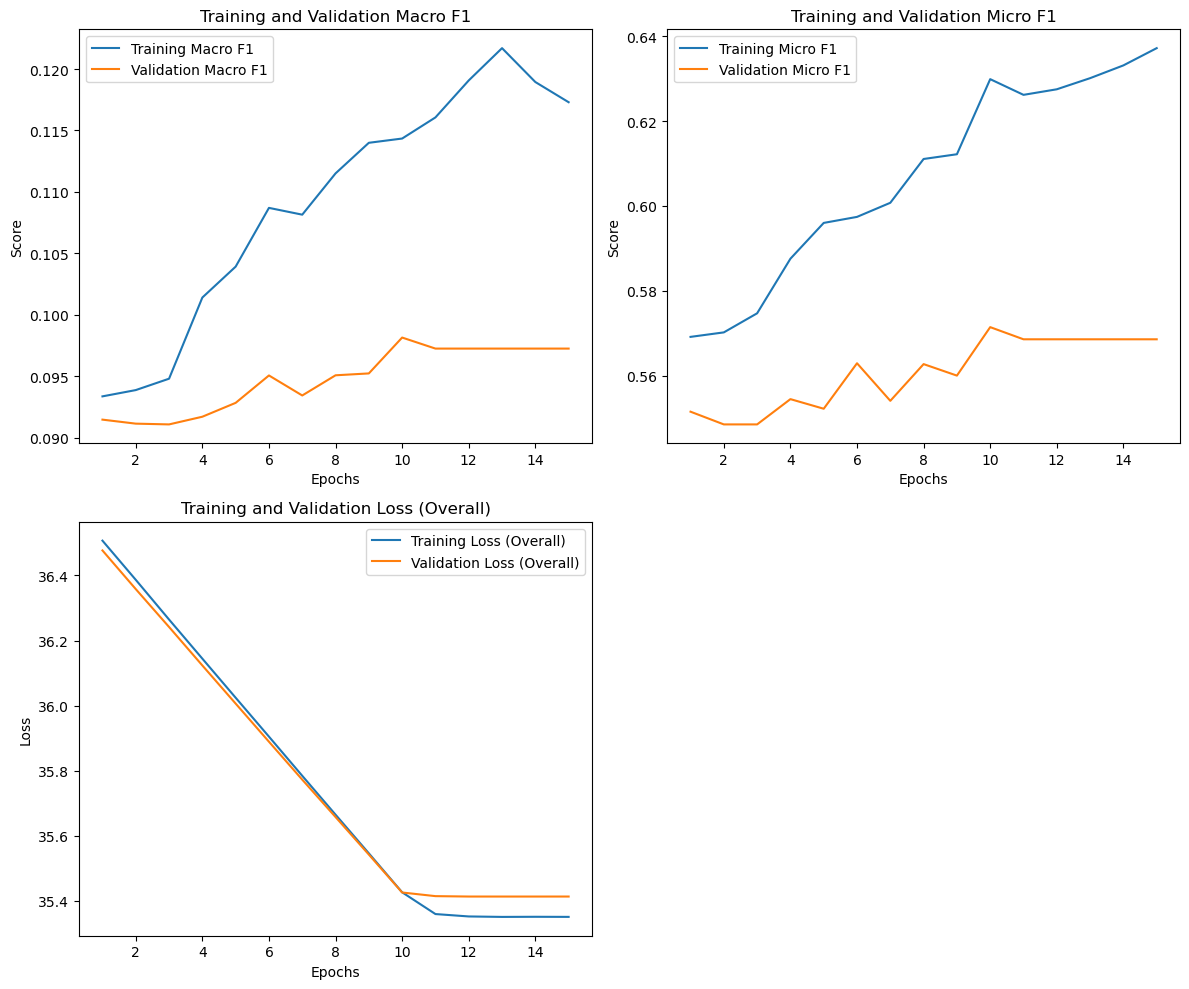

In [77]:
plot_history(history)

**OBSERVATIONS**

Interestingly, when comparing the fine-tuned model, where only ALBERT was fine-tuned, to our current best model, we observe a slight drop in the F1 score in the version where both ALBERT and ResNet50 were fine-tuned. This suggests that while fine-tuning both components together might intuitively seem like it would improve performance, it actually led to worse results, which aligns with our original strategy for the baseline model (not training the visual extractor). This could be due to several reasons.

**POSSIBLE CAUSE**

One possible explanation is that fine-tuning both models simultaneously may have disrupted the well-learned features of ResNet50, which were pretrained on a large-scale image dataset (ImageNet). When fine-tuned on our comparatively smaller and specific meme dataset, ResNet50 might have lost some of its generalized image understanding, leading to a decrease in performance. In contrast, fine-tuning ALBERT alone likely allowed the model to better adapt to the unique text features in the memes, while the frozen ResNet50 maintained its robust visual representations.

Another factor could be the complex interactions between the two modalities—images and text. By fine-tuning both simultaneously, the model might have struggled to balance the contributions from each modality, particularly since memes often involve intricate relationships between text and image content. As a result, fine-tuning only the text branch (ALBERT) may have been more effective in maintaining a balance between both modalities.

**NEXT STEP**

To confirm this hypothesis, we will retrain the model, this time with only ALBERT fine-tuned while keeping ResNet50 frozen. This will help verify whether focusing on fine-tuning the text branch without altering the image branch leads to better results. If successful, it will further support the idea that the text-based nuances of memes benefit more from fine-tuning, while the pretrained image features from ResNet50 remain adequate for this task without further adjustments.

This retraining process aims to solidify our understanding of how much each modality contributes to the model’s performance and whether fine-tuning both components is necessary—or if, in fact, focusing on one modality can provide better results.

### Model with only ALBERT finetuned

In [61]:
model = MemeClassifier(embd_dim=128, ff_dim=128,)

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000005)
model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1),
              metrics=get_metrics())

c:\Users\LENOVO\anaconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
history = model.fit(train_ds, validation_data=dev_ds, epochs=20, callbacks=get_cbs([lr_scheduler]), verbose=False)

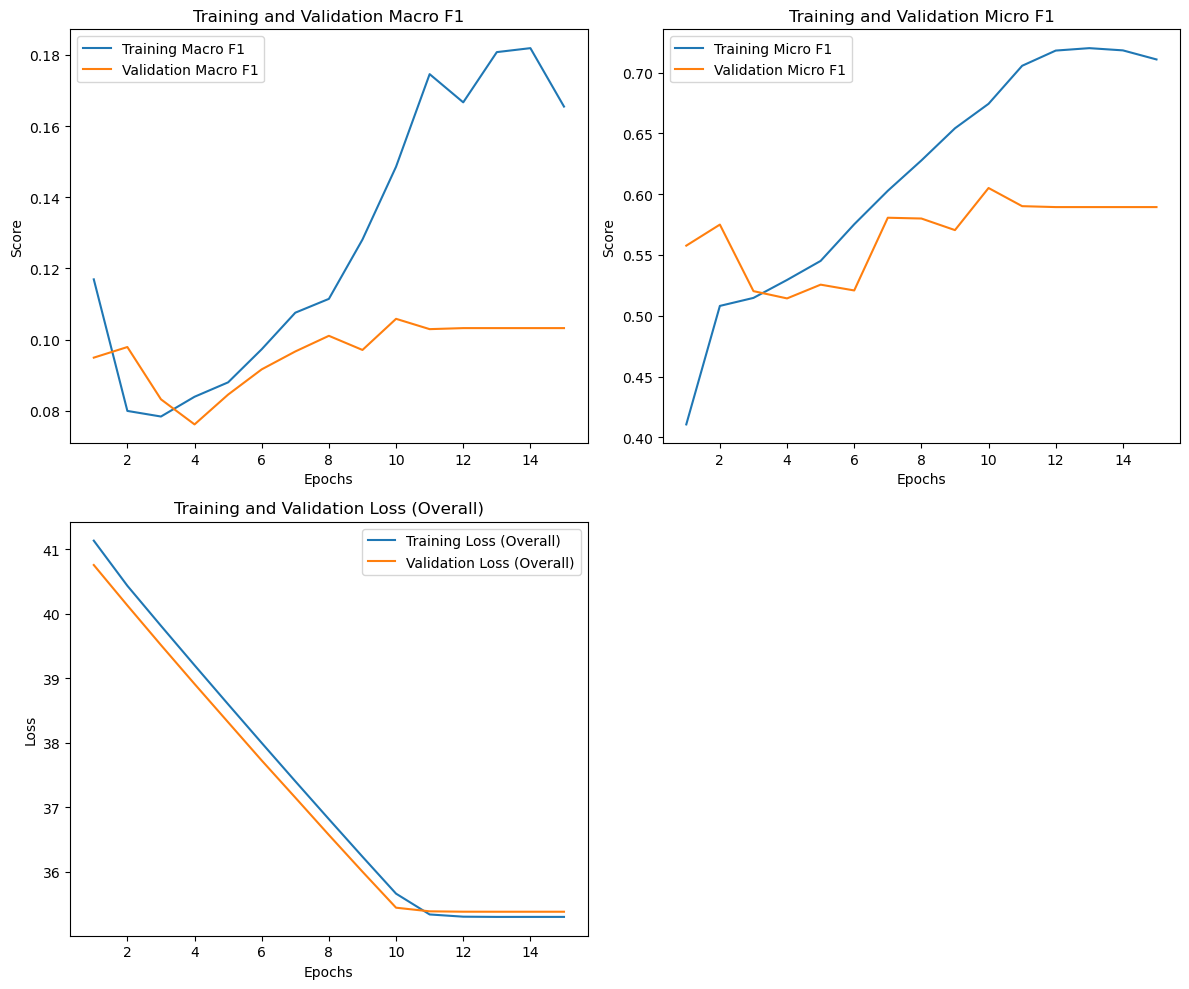

In [64]:
plot_history(history)

In [63]:
model.evaluate(test_ds)

49/49 [==============================] - 8s 155ms/step - loss: 35.4561 - F1_Macro: 0.0947 - F1_Micro: 0.5083


[35.4560546875, 0.09470720589160919, 0.5083240866661072]

**ANALYSIS**

Upon closer analysis, we can clearly see that the model performs better when ResNet50 remains frozen and only ALBERT is fine-tuned. This version of the model achieved a higher F1 score for both macro and micro F1 metrics compared to when we fine-tuned both ALBERT and ResNet50. Notably, the model also shows less signs of overfitting, as evidenced by a smoother, more stable loss curve, and it even outperforms the original model with less training. This suggests that the improvement in accuracy is not merely by chance, but a result of the strategy where we fine-tune only the text module (ALBERT) while keeping the image module (ResNet50) intact.

One plausible reason for this outcome is that ResNet50, pretrained on large image datasets such as ImageNet, is already highly effective at extracting relevant and rich features from images. These learned features are quite general and versatile, which allows ResNet50 to perform well even on smaller, task-specific datasets like ours. When we attempt to fine-tune ResNet50 on a small, specialized dataset (such as memes), we run the risk of distorting these well-learned features, which can lead to a decline in performance. Fine-tuning on small datasets may cause the model to overfit or focus too much on task-specific nuances, compromising the strong generalization ability it originally had from its pretraining on ImageNet.

On the other hand, by keeping ResNet50 frozen, we allow the model to retain these strong, generalizable image features. This frees up the fine-tuning process to focus solely on adapting the text module (ALBERT) to the specific nature of the memes. Memes typically involve complex, nuanced language, so fine-tuning ALBERT makes it more adept at extracting the specific textual features required for this task. This approach strikes a better balance between the two modalities, leading to a model that performs well across both text and image inputs.

**NEXT STEP**

At this stage, even though the Micro F1 score is exceeding our expectations and is significantly higher than the target, the Macro F1 score still falls short. This discrepancy indicates that the model is performing well on majority classes (which is reflected in the high Micro F1 score) but continues to struggle with minority classes, hence the lower Macro F1 score. Our goal is to balance these two metrics, ensuring that the model performs well not only on frequent classes but also on the rarer, underrepresented ones.

To achieve this, our next step will be to focus on hyperparameter tuning. By adjusting parameters such as learning rate, batch size, and thresholds for classification, we aim to further improve the performance of the model on both Macro and Micro F1 scores. Additionally, exploring threshold tuning for each label might help the model better differentiate between classes, especially the minority ones. This fine-tuning of the model’s behavior could help ensure that both majority and minority classes are treated fairly, resulting in a more balanced and robust performance across all labels.

## Hyperparameter tuning

**STRATEGY**

Given our limited computational power, fine-tuning complex parameters like the number of heads, encoders, and decoders in models like ALBERT is not feasible. These adjustments are resource-intensive and time-consuming due to the randomness in training. Instead, we will focus on a more manageable strategy: threshold tuning for each label after fine-tuning.

This approach doesn’t require retraining the model and is computationally efficient. By adjusting the classification thresholds for each label, we can better balance precision and recall, particularly improving the Macro F1 score and enhancing performance on minority classes. This method is practical for our resource constraints and can significantly boost performance without extensive parameter searches.

In [114]:
y_pred_prob = model.predict(dev_ds)

15/15 [==============================] - 2s 106ms/step


In [115]:
# Extract y from the dataset
y_true = []

for batch in dev_ds:
    X_batch, y_batch = batch  
    y_true.append(y_batch.numpy())  

y_true = np.concatenate(y_true, axis=0)

In [116]:
y_true.shape == y_pred_prob.shape

True

In [117]:
thresholds = np.arange(0.0, 0.9, 0.01)
best_thresholds = np.zeros(y_true.shape[1])

In [118]:
for label_idx in range(y_true.shape[1]):
    # Check if there are no true positives (i.e., no 1's in true labels for this label)
    no_true_positives = np.all(y_true[:, label_idx] == 0)
    
    # Check if there are no predicted positives (i.e., no 1's in predicted labels for this label)
    no_predicted_positives = np.all(y_pred_prob[:, label_idx] == 0)
    
    # Print out the results
    if no_true_positives:
        print(f"Label {label_idx}: No true positives in true labels.")
    if no_predicted_positives:
        print(f"Label {label_idx}: No predicted positives from model.")

    if no_true_positives and no_predicted_positives:
        print(f"Label {label_idx}: No true positives and no predicted positives for this label.\n")


Label 2: No true positives in true labels.
Label 11: No true positives in true labels.
Label 12: No true positives in true labels.


There is a problem in the development dataset where for some labels there are no true labels, resulting in possible warnings, but we can ignore it

In [134]:
best_f1 = 0
best_threshold = 0

macro_f1_scores = []
micro_f1_scores = []

# Iterate over different thresholds to find the optimal one
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    predicted_labels = (y_pred_prob > threshold).astype(int)
    
    # Calculate F1 scores for the current threshold
    macro_f1 = f1_score(y_true, predicted_labels, average='macro', zero_division=1)
    micro_f1 = f1_score(y_true, predicted_labels, average='micro', zero_division=1)
    
    # Store the F1 scores for visualization
    macro_f1_scores.append(macro_f1)
    micro_f1_scores.append(micro_f1)
    
    print(f"Threshold: {threshold}, Macro F1: {macro_f1:.4f}, Micro F1: {micro_f1:.4f}")
    
    # Update the best threshold if the current F1-score is higher
    if macro_f1 > best_f1:
        best_f1 = macro_f1
        best_threshold = threshold

Threshold: 0.0, Macro F1: 0.2031, Micro F1: 0.2435
Threshold: 0.01, Macro F1: 0.2031, Micro F1: 0.2435
Threshold: 0.02, Macro F1: 0.2031, Micro F1: 0.2437
Threshold: 0.03, Macro F1: 0.2038, Micro F1: 0.2461
Threshold: 0.04, Macro F1: 0.2035, Micro F1: 0.2535
Threshold: 0.05, Macro F1: 0.2079, Micro F1: 0.2746
Threshold: 0.06, Macro F1: 0.2162, Micro F1: 0.3035
Threshold: 0.07, Macro F1: 0.2069, Micro F1: 0.3287
Threshold: 0.08, Macro F1: 0.2175, Micro F1: 0.3622
Threshold: 0.09, Macro F1: 0.2286, Micro F1: 0.3985
Threshold: 0.1, Macro F1: 0.2365, Micro F1: 0.4268
Threshold: 0.11, Macro F1: 0.2309, Micro F1: 0.4415
Threshold: 0.12, Macro F1: 0.2437, Micro F1: 0.4738
Threshold: 0.13, Macro F1: 0.2475, Micro F1: 0.4966
Threshold: 0.14, Macro F1: 0.2451, Micro F1: 0.5108
Threshold: 0.15, Macro F1: 0.3047, Micro F1: 0.5348
Threshold: 0.16, Macro F1: 0.3077, Micro F1: 0.5437
Threshold: 0.17, Macro F1: 0.2977, Micro F1: 0.5544
Threshold: 0.18, Macro F1: 0.2988, Micro F1: 0.5630
Threshold: 0.1

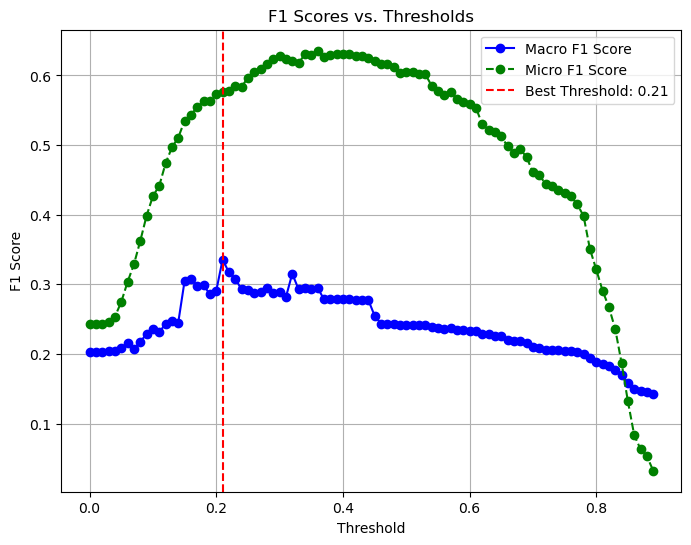

In [135]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, macro_f1_scores, label='Macro F1 Score', marker='o', linestyle='-', color='b')
plt.plot(thresholds, micro_f1_scores, label='Micro F1 Score', marker='o', linestyle='--', color='g')

# Highlight the best threshold
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold}')

plt.title('F1 Scores vs. Thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid(True)

plt.show()

In [136]:
print(f"Best Threshold: {best_threshold}, Best Macro F1 Score: {best_f1}")

Best Threshold: 0.21, Best Macro F1 Score: 0.3354674090148338


Although a threshold of 0.21 provides the highest Macro F1 score, we will choose 0.28 as it offers the highest Micro F1 score while still maintaining a relatively high Macro F1 score. This strikes a better balance between the model’s performance on majority classes (Micro F1) and minority classes (Macro F1), ensuring that the model performs well across all labels, not just the minority ones

### Evaluate

In [146]:
# Get final model's macro and micro f1 score based on the best threshold
threshold = 0.28
test_pred_prob = model.predict(test_ds)
test_pred_prob = (test_pred_prob > threshold).astype(int)

49/49 [==============================] - 6s 109ms/step


In [147]:
# Extract y from the dataset
test_true = []

for batch in test_ds:
    X_batch, y_batch = batch  
    test_true.append(y_batch.numpy())  

# Concatenate all batches into a single array
test_true = np.concatenate(test_true, axis=0)

In [149]:
# Compute macro and micro f1 score
macro_f1 = f1_score(test_true, test_pred_prob, average='macro') 
micro_f1 = f1_score(test_true, test_pred_prob, average='micro')
average_f1 = f1_score(test_true, test_pred_prob, average='weighted')
print(f"Macro F1-score: {macro_f1}, Micro F1-score: {micro_f1}, Average F1-score: {average_f1}")

Macro F1-score: 0.15827830632619738, Micro F1-score: 0.49868766404199477, Average F1-score: 0.40479884986421466


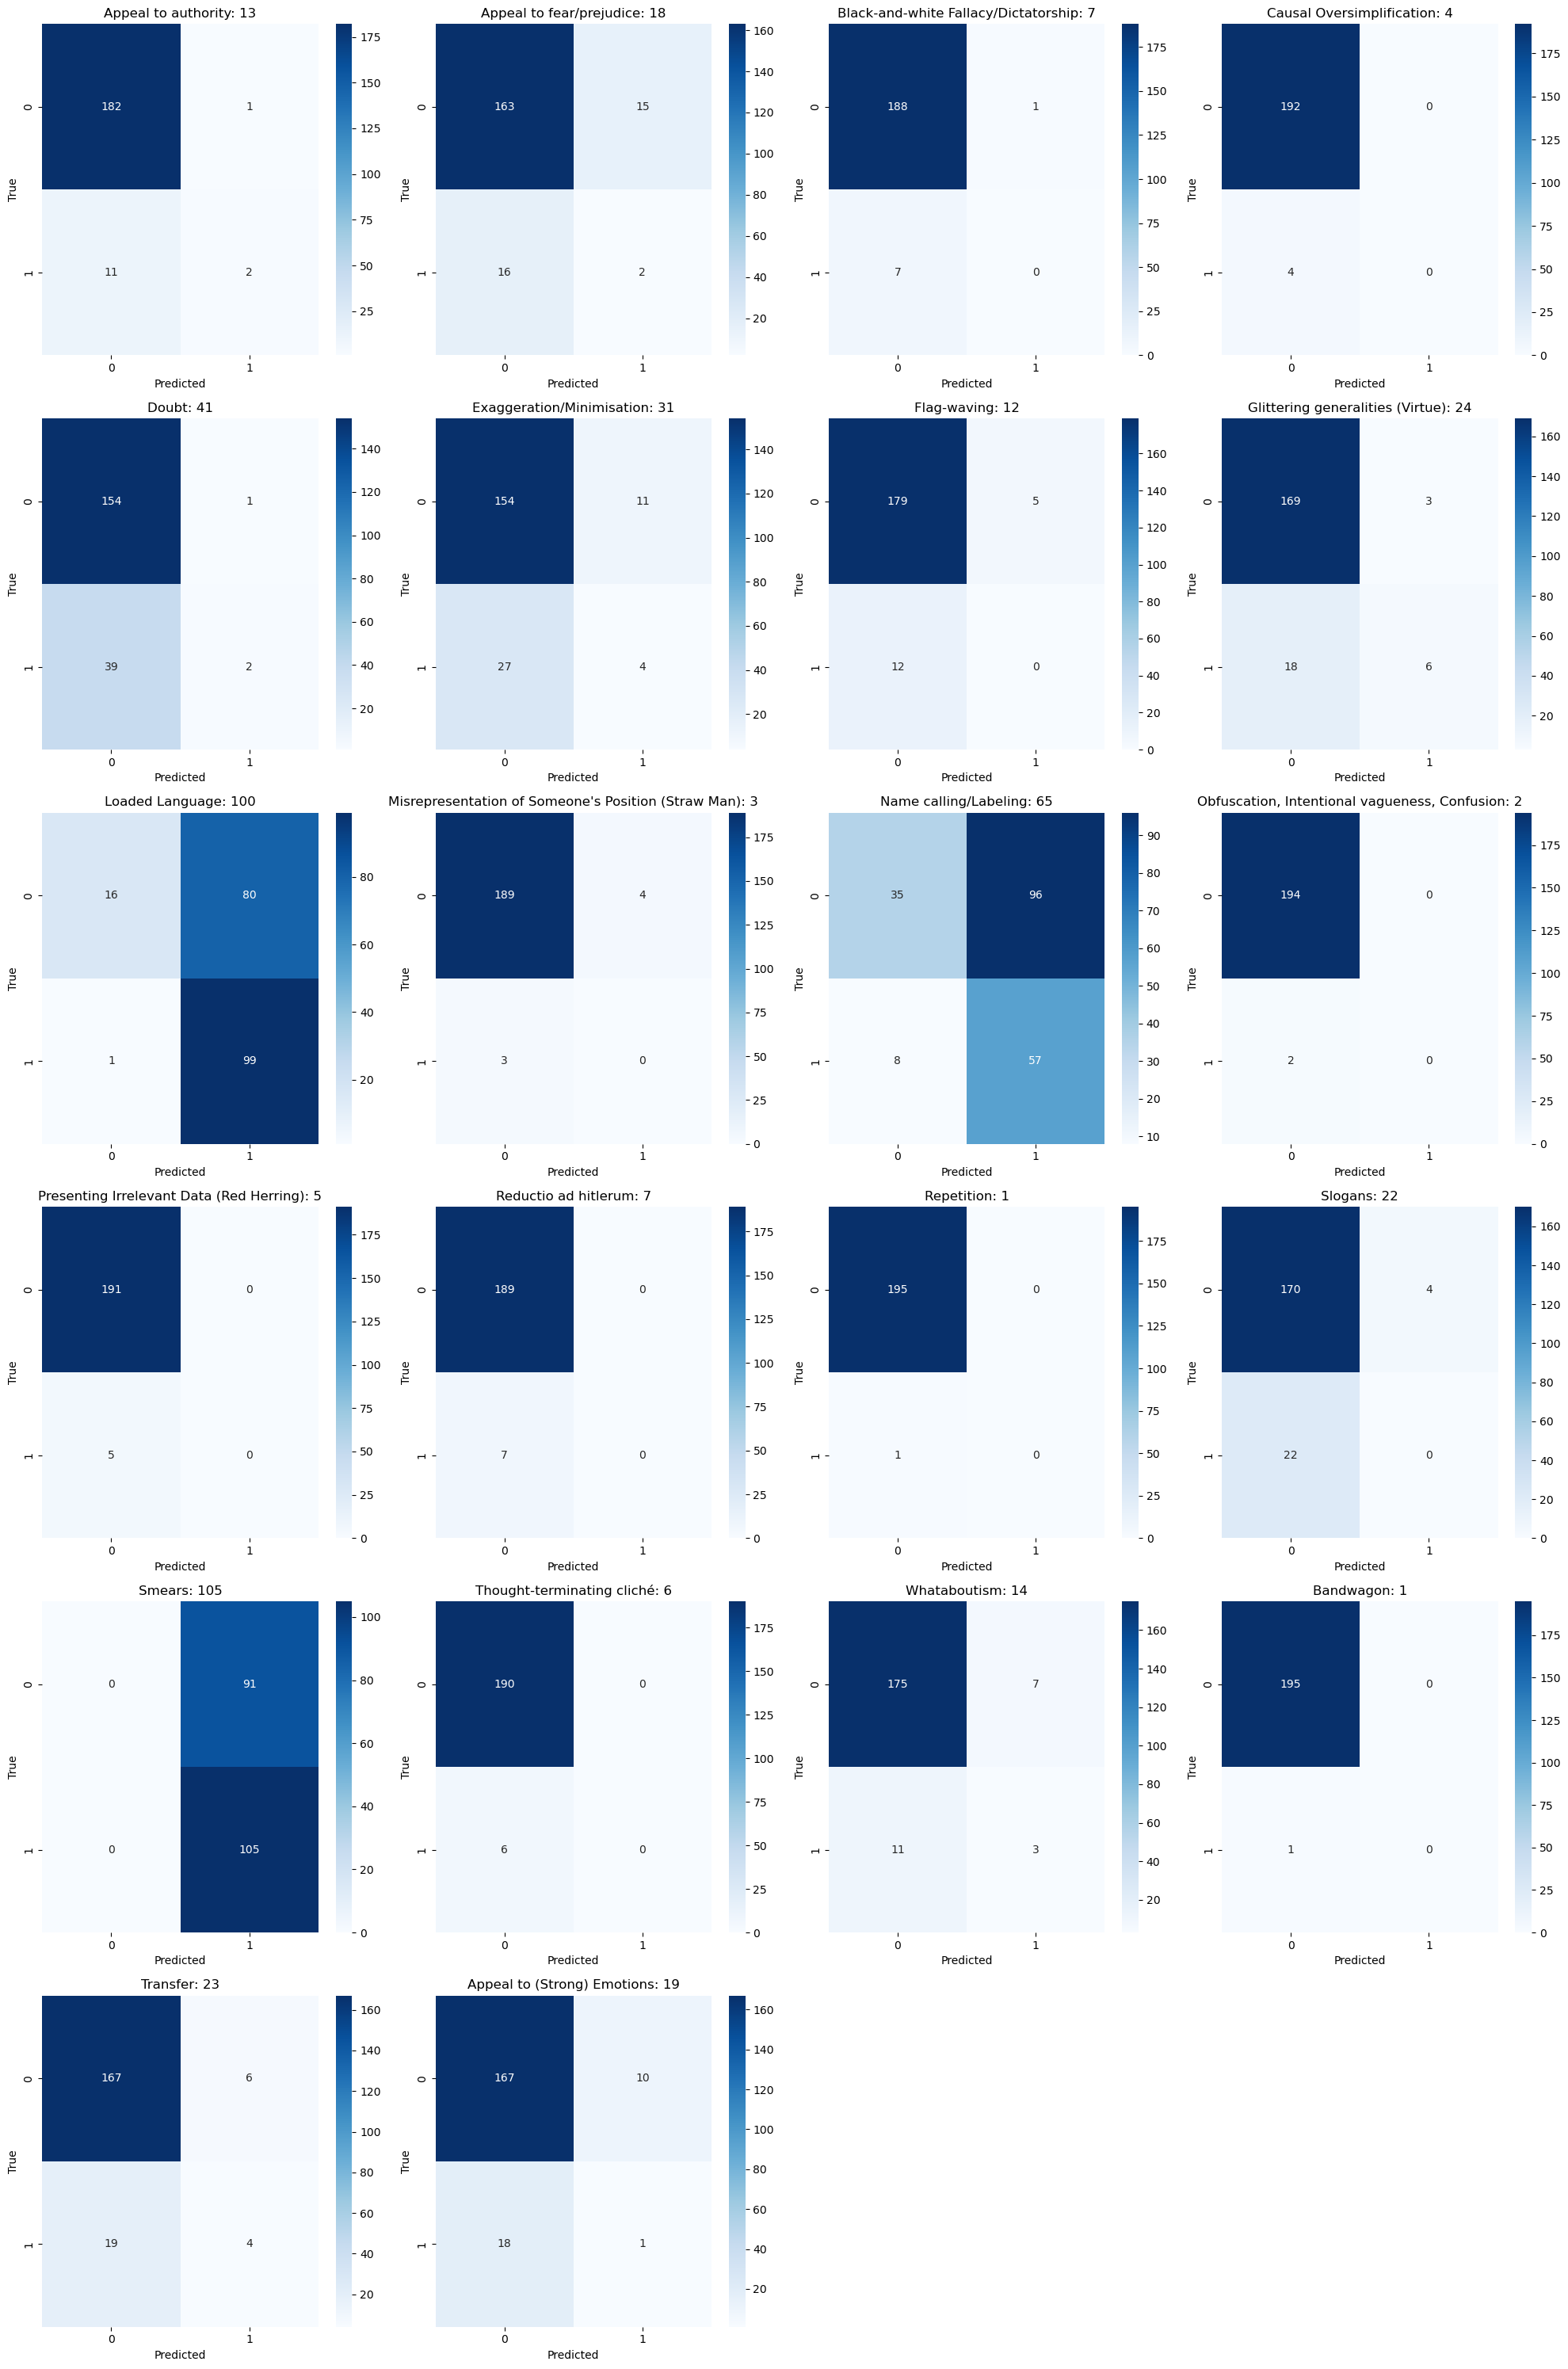

In [128]:
multilabel_heatmap(test_ds, model, threshold=0.28)

By fine-tuning the threshold, we significantly improved the Macro F1 score to 0.158, a 1.7x increase, while only sacrificing a small amount of performance in the Micro F1 score (which dropped slightly from 0.508 to 0.498). This represents a clear improvement over the original model, with a much higher average F1 score, as reflected in the comparison of the two heatmaps.

Specifically:

- For common labels like "Smears," the model now correctly predicts most cases, though it occasionally misclassifies other samples as "Smears."
- For less common labels like "Appeal to Authority" and "Virtue," where the model previously struggled, it is now making correct predictions for some of these cases.
- Even for rare labels like "Whataboutism," the model has begun to make correct predictions, which is a significant improvement.

The most notable enhancement is the model's ability to predict a broader range of labels in the dataset. Previously, it focused heavily on the most common classes, but after threshold tuning, it shows better balance by attempting predictions across a wider variety of labels, including the rarer ones, even if some predictions are still incorrect. This increased diversity in label prediction indicates a more balanced and well-rounded performance.

## Ultimate Judgement

### Final model selection

For the final model, I selected the proposed architecture, featuring a fine-tuned text module (ALBERT) and a threshold of 0.28. This choice was driven by the model’s strong performance, achieving Macro F1 and Micro F1 scores of 0.15 and 0.498, respectively, on the test dataset. These scores represent a significant improvement over the baseline model and would have placed the model 8th in the original competition, even with limited computational resources.

In addition to surpassing the baseline, this model outperformed all previous iterations in the notebook, showing superior results for both Macro and Micro F1 metrics. This indicates a well-balanced performance, not only excelling in majority classes but also improving prediction accuracy for minority classes—one of the key goals for this task.

Overall, the final model not only met but exceeded the target performance metrics. It demonstrated strong generalization across different labels, showing better attention to both majority and minority classes without overly focusing on the former. However, despite these achievements, there remain some limitations that could be addressed in future work. For instance, further exploration of different loss functions, advanced threshold tuning techniques, or incorporating additional data augmentation strategies could further enhance the model's ability to handle rare labels and improve generalization. Moreover, utilizing more computational resources or larger pretrained models might unlock additional performance gains.

### Real world challenges

While the model performs well for the most common classes, it continues to struggle with the less common ones, even after adjusting the classification threshold. Many minority classes are still misclassified, and for some labels, like Bandwagon, the model fails to predict any instances correctly. This is largely due to the imbalanced nature of the dataset, where certain labels appear very rarely. For example, the Bandwagon label is present fewer than 10 times in the entire dataset. With such a limited number of examples, the model finds it challenging to learn meaningful patterns or representations for these rare labels.

In real-world applications, the model's strong performance on more common labels, such as Smears (the most frequent label), would likely prove useful, as these labels are more likely to appear in actual use cases. However, for rarer labels, the model struggles because it hasn’t seen enough instances to develop a robust understanding of these categories. This imbalance impacts the model’s Macro F1 score, which reflects its performance across all labels, especially the less frequent ones.

To address this limitation and improve the model’s ability to handle minority classes, one option is to use a larger and more powerful text model, such as RoBERTa or DeBERTa. These models have more parameters and better capacity to capture nuanced relationships in text, which could help the model better understand and classify rare labels. However, this approach requires significantly more computational resources than what is typically available on a local machine, and running such large models may necessitate access to more powerful hardware, such as GPUs or cloud-based services.

Another potential solution is to collect more data, particularly for the underrepresented labels. With more examples, the model would have a better chance of learning useful patterns for minority classes, which could lead to a higher Macro F1 score and better overall performance. However, gathering more data can be time-consuming and resource-intensive, and it may not always be practical.

In summary, while the current model excels with common labels, its performance on rare labels remains a challenge due to the inherent data imbalance. Addressing this issue could involve either leveraging more powerful models or expanding the dataset to provide the model with more representative examples for minority classes. Both approaches, though resource-intensive, offer promising ways to improve the model's ability to predict across a broader range of labels.

# Enhancement Task

## PDA

### Load data

In [28]:
# Get all classes present
with open('enhancement/techniques_list_task2.txt', 'r') as file:
    # Read each line and store them as elements in a list
    techniques = [line.strip() for line in file if line.strip()]

techniques

['Appeal to authority',
 'Appeal to fear/prejudice',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism',
 'Bandwagon']

In [29]:
len(techniques)

20

Different from main task, in the enhancement task, there are 20 classes

In [30]:
# Load the text data
with open('enhancement/training_set_task2.txt', 'r') as file:
    train_json = json.load(file)

with open('enhancement/test_set_task2.txt', 'r') as file:
    test_json = json.load(file)

with open('enhancement/dev_set_task2.txt', 'r') as file:
    dev_json = json.load(file)

In [31]:
train_json[0]

{'id': '128',
 'text': 'THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n',
 'labels': [{'start': 0,
   'end': 41,
   'technique': 'Black-and-white Fallacy/Dictatorship',
   'text_fragment': 'THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE'}]}

In [32]:
test_json[0]

{'id': '705_batch_2',
 'text': 'The Democrats New America\n',
 'labels': [{'start': 0,
   'end': 25,
   'technique': 'Name calling/Labeling',
   'text_fragment': 'The Democrats New America'},
  {'start': 0,
   'end': 25,
   'technique': 'Slogans',
   'text_fragment': 'The Democrats New America'}]}

In [33]:
dev_json[0]

{'id': '62_batch_2',
 'text': '*President* Biden?\n\nPlease, no.\n',
 'labels': []}

### Visualize an instance

In [34]:
print("TEXT: ")
print(dev_json[0]['text'])
print("\nLABELS:")
print(dev_json[0]['labels'])

TEXT: 
*President* Biden?

Please, no.


LABELS:
[]


### Missing labels

In [35]:
count = 0
for sample in dev_json:
    if sample['labels'] == []:
        count += 1

count

15

In [36]:
count = 0
for sample in train_json:
    if sample['labels'] == []:
        count += 1

count

143

In [37]:
count = 0
for sample in test_json:
    if sample['labels'] == []:
        count += 1

count

41

Let's take a look at some samples with missing labels to figure out if there’s an issue with the dataset. This will help us understand whether these samples should actually have labels or if they simply don’t belong to any of the categories

In [38]:
for sample in dev_json:
    if sample['labels'] == []:
        print(sample['text'])
        break

*President* Biden?

Please, no.



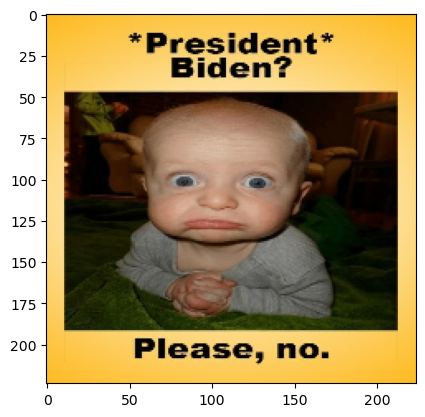

In the main task, this sample has two labels: "Doubt" and "Smears." However, it seems the dataset creator may have missed assigning these labels to this specific sample. To fix this issue, we can simply remove these samples from the dataset

In [39]:
# Delete samples with missing labels
train_json = [sample for sample in train_json if sample['labels'] != []]

# Remove samples with empty labels from test_json
test_json = [sample for sample in test_json if sample['labels'] != []]

# Remove samples with empty labels from dev_json
dev_json = [sample for sample in dev_json if sample['labels'] != []]

In [40]:
# Verify if deleted
count = 0
for sample in test_json:
    if sample['labels'] == []:
        count += 1
        print(sample['id'])

count

0

We also need to check for other missing values in other columns

In [41]:
for sample in dev_json:
    if sample['text'] == "":
        print(sample['text'])
        
for sample in train_json:
    if sample['text'] == "":
        print(sample['text'])
        
for sample in test_json:
    if sample['text'] == "":
        print(sample['text'])
        
for sample in dev_json:
    if sample['id'] == "":
        print(sample['text'])
        
for sample in train_json:
    if sample['id'] == "":
        print(sample['text'])
        
for sample in test_json:
    if sample['id'] == "":
        print(sample['text'])

We have checked and removed all samples with missing values from the dataset

### Data distribution

In [42]:
# Function to plot label distribution
def plot_dist(data, title):
    all_labels = []

    for sample in data:
        for label in sample['labels']:
            all_labels.append(label['technique'])

    # Count occurrences
    label_counts = Counter(all_labels)

    labels = [str(label) for label in label_counts.keys()]

    counts = label_counts.values()

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate labels for better readability
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

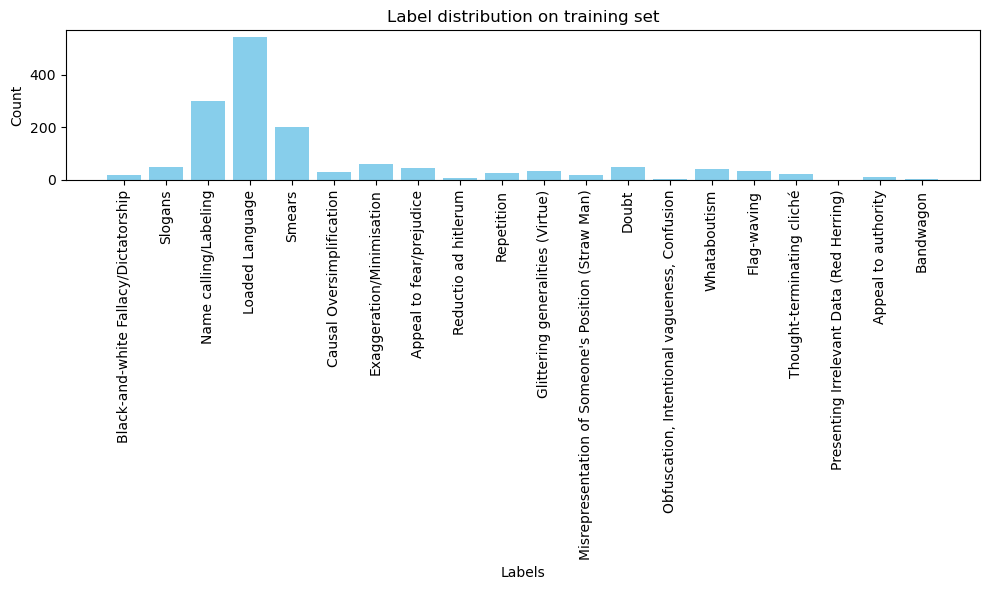

In [43]:
plot_dist(train_json, 'Label distribution on training set')

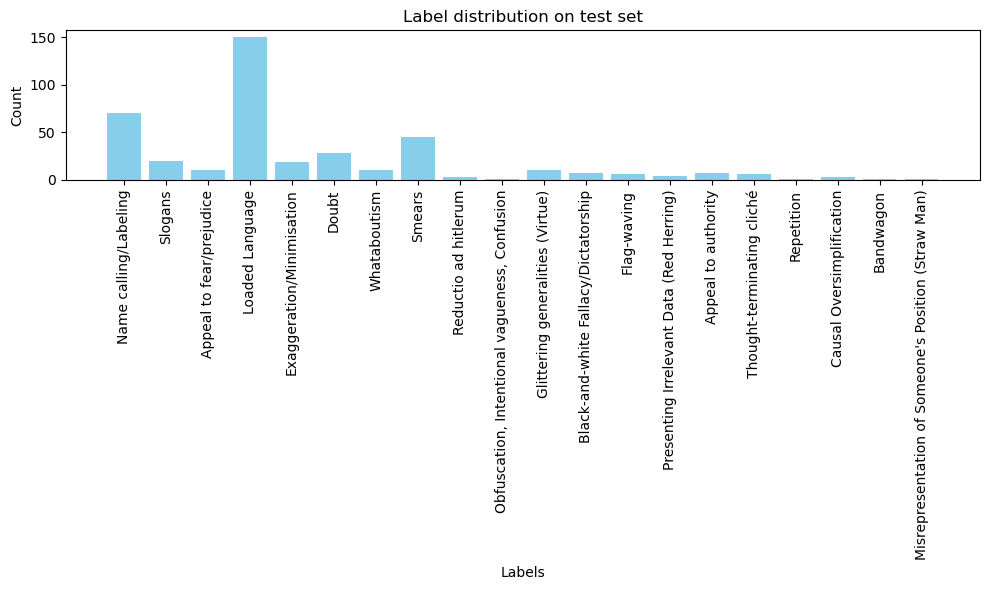

In [44]:
plot_dist(test_json, 'Label distribution on test set')

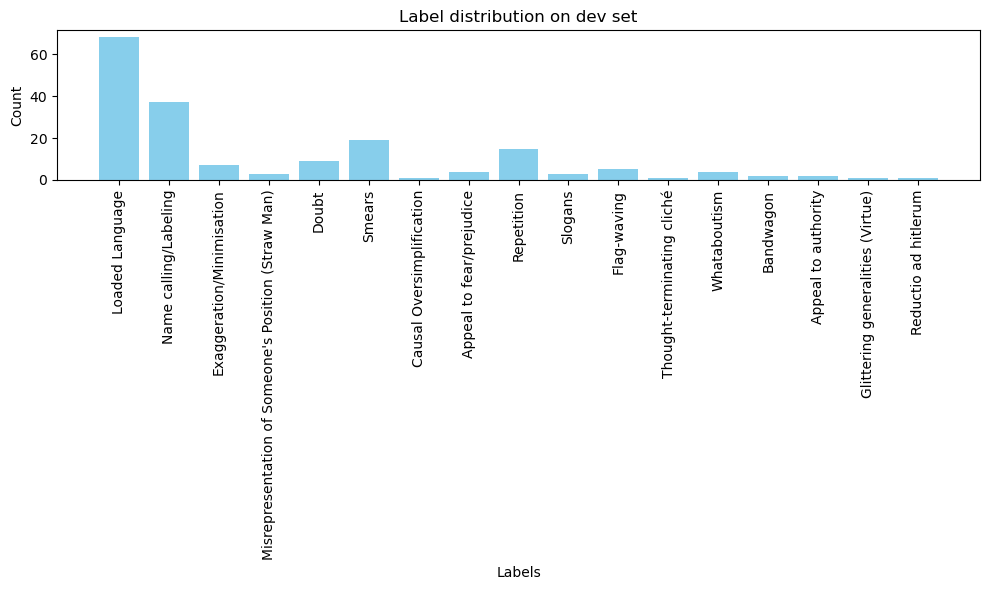

In [45]:
plot_dist(dev_json, 'Label distribution on dev set')

In the training dataset, we observe that labels like Smears, Name Calling, and Loaded Language are the most frequent, with over 200 entries each. However, other labels like Bandwagon and Repetition have fewer than 10 entries, highlighting the extreme imbalance in the dataset. Additionally, some labels, such as Black and White Fallacy, are missing entirely from the development dataset. Because of this imbalance, we need to use different metrics other than accuracy

### Preprocess

Similar to the main task, some text are written in all caps, and contain consecutive newline characters. In the enhancement task, we will perform the same preprocessing steps, however, now also applied to the text_fragment 

In [46]:
for sample in train_json:
    # Lowercase the main text
    sample['text'] = sample['text'].lower().replace('\n\n', '[SEP]')
    
    # Lowercase each text fragment in the labels
    for label in sample['labels']:
        label['text_fragment'] = label['text_fragment'].lower().replace('\n\n', '[SEP]')

for sample in test_json:
    # Lowercase the main text
    sample['text'] = sample['text'].lower().replace('\n\n', '[SEP]')
    
    # Lowercase each text fragment in the labels
    for label in sample['labels']:
        label['text_fragment'] = label['text_fragment'].lower().replace('\n\n', '[SEP]')

for sample in dev_json:
    # Lowercase the main text
    sample['text'] = sample['text'].lower().replace('\n\n', '[SEP]')
    
    # Lowercase each text fragment in the labels
    for label in sample['labels']:
        label['text_fragment'] = label['text_fragment'].lower().replace('\n\n', '[SEP]')

## Setup Helper functions

In [47]:
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr  # Keep the initial learning rate for the first 10 epochs
    elif 10 <= epoch < 20:
        return lr * 0.1  # Reduce learning rate by a factor of 10 after epoch 10

In [ ]:
def multilabel_heatmap(ds, model, threshold=0.5):
    # Prepare lists to hold the true labels and predictions
    true_labels = []
    pred_labels = []

    # Iterate through the dataset
    for data_batch, label_batch in ds:
        input_ids, attention_mask = data_batch
        labels = label_batch.numpy()

        # Get model predictions
        predictions = model.predict(data_batch, verbose=False)

        # Apply threshold to predictions
        predictions = (predictions > threshold).astype(int)

        # Flatten labels and predictions, ignore padding tokens (assuming -1 or 0 for padding in labels)
        for i in range(labels.shape[0]):
            mask = attention_mask[i].numpy().astype(bool)  # Get attention mask to ignore padded tokens
            true_labels.append(labels[i][mask])  # Keep only the labels for non-padded tokens
            pred_labels.append(predictions[i][mask])  # Keep only the predictions for non-padded tokens

    # Convert lists of labels and predictions to numpy arrays
    true_labels = np.concatenate(true_labels, axis=0)
    pred_labels = np.concatenate(pred_labels, axis=0)

    # Count the occurrences of each label
    label_counts = np.sum(true_labels, axis=0)

    # Compute the multilabel confusion matrix
    conf_matrix = multilabel_confusion_matrix(true_labels, pred_labels)

    num_labels = true_labels.shape[1]

    # Create subplots for each label
    fig, axs = plt.subplots(6, 4, figsize=(20, 30))
    axs = axs.flatten()

    for i in range(num_labels):
        # Visualize the confusion matrix for each label
        sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', ax=axs[i])
        axs[i].set_xlabel('Predicted')
        axs[i].set_ylabel('True')
        axs[i].set_title(f'{techniques[i]}: {label_counts[i]}')  # Update title to reflect label counts

    # Remove extra subplots if not needed
    for j in range(num_labels, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

In [48]:
# Helper function to redefine callbacks
def get_cbs(cbs=[]):
  res_cbs = []
  for cb in cbs:
    res_cbs.append(cb)

  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_F1", mode="max")
  res_cbs.append(early_stopping_cb)
  
  return res_cbs

In [347]:
def vis_pred(model, ds, threshold=0.5):
    # Get a batch of data and labels
    data_batch, label_batch = next(iter(ds))
    input_ids, _ = data_batch
    input_id = input_ids[0].numpy()
    label = label_batch[0].numpy()
    
    # Decode the input IDs to text
    decoded_text = albert_tokenizer.decode(input_id, skip_special_tokens=True)
    
    # Get model predictions
    preds = model.predict(data_batch, verbose=False)
    preds = tf.cast(preds > threshold, dtype=tf.int32)  # Apply threshold
    pred = preds[0].numpy()

    # Visualize the labels per token (True Labels & Predicted Labels)
    token_labels = []
    pred_labels = []
    
    for i, token_id in enumerate(input_id):
        # Skip special tokens (e.g., [PAD])
        if token_id == albert_tokenizer.pad_token_id:
            continue
        
        # Get true labels for the current token
        true_active_labels = [index_to_label[idx] for idx, value in enumerate(label[i]) if value == 1]
        # Get predicted labels for the current token
        pred_active_labels = [index_to_label[idx] for idx, value in enumerate(pred[i]) if value == 1]
        
        # Decode the token itself
        token = albert_tokenizer.decode([token_id])
        
        if true_active_labels or pred_active_labels:
            # Store both true and predicted labels for visualization
            token_labels.append((token, true_active_labels, pred_active_labels))

    # Print the decoded text
    print(f"Decoded text: {decoded_text}\n")
    
    # Print out the token-level labels (both true and predicted)
    print(f"{'Token':<15}{'True Labels':<30}")
    print("="*100)

    for token, true_label, pred_label in token_labels:
        print(f"{token:<15}{', '.join(true_label):<30}")
        
    print("-"*100)
    print(f"{'Token':<15}{'Predicted Labels':<30}")
    print("="*100)
    for token, true_label, pred_label in token_labels:
        print(f"{token:<15}{', '.join(pred_label)}")

In [49]:
def get_metrics():
    return [
        tfa.metrics.F1Score(num_classes=len(techniques), threshold=0.5, name="F1", average='micro'), 
        tf.keras.metrics.Precision(name="Precision"),
        tf.keras.metrics.Recall(name="Recall"),
    ]

In [50]:
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].plot(epochs, history.history['F1'], label='Training F1')
    axs[0, 0].plot(epochs, history.history['val_F1'], label='Validation F1')
    axs[0, 0].set_title('Training and Validation F1')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Score')
    axs[0, 0].legend()

    axs[0, 1].plot(epochs, history.history['Recall'], label='Training Recall')
    axs[0, 1].plot(epochs, history.history['val_Recall'], label='Validation Recall')
    axs[0, 1].set_title('Training and Validation Recall')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Score')
    axs[0, 1].legend()
    
    # Plot overall loss
    axs[1, 0].plot(epochs, history.history['loss'], label='Training Loss (Overall)')
    axs[1, 0].plot(epochs, history.history['val_loss'], label='Validation Loss (Overall)')
    axs[1, 0].set_title('Training and Validation Loss (Overall)')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()
    
    axs[1, 1].plot(epochs, history.history['Precision'], label='Training Precision')
    axs[1, 1].plot(epochs, history.history['val_Precision'], label='Validation Precision')
    axs[1, 1].set_title('Training and Validation Precision')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Score')
    axs[1, 1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Aproach

### Address data imbalance

We are facing challenges with label imbalance in our dataset, similar to the main task. To address this, we cantake a similar approach by using Focal loss, which is designed to focus on hard-to-classify examples. However, since Focal loss alone might not fully resolve the issue, we will also tune the decision thresholds to improve the final model's performance on the metrics

### Target goals

**Metric selection**

For our metrics, we choose the micro F1 score, precision, and recall for the following reasons:
- Precision helps us understand how well the model avoids false positives.
- Recall tells us how well the model captures true positives and avoids false negatives.
- The F1 score combines precision and recall, giving a balanced view of the model's overall performance by highlighting the trade-offs between them. This gives us a clearer picture of how well the model is performing.

In the original competition, the official metric was micro F1, with the random baseline scoring just 0.01. The top three models, which used large language models like BERT, achieved scores between 0.4 and 0.5. Given our limited computational resources, we are setting a target of 0.25 for our final model’s micro F1 score on the test set.

We are also aiming for 0.25 in both precision and recall on the test set. This would show that our model has a good balance between making correct positive predictions and successfully identifying all relevant instances.

## Baseline

**Overview**

The baseline model uses a pretrained text model to extract features from the text, followed by a Dense layer with a sigmoid activation. This setup is similar to the baseline model used for the main task, except it doesn't include the image component. The main difference, however, is in the target that the model is aiming to predict which lies in the data loading process

**Optimizer**: We choose nadam for faster convergence

**Justification for model structure**:

Similar to the main task, since memes often contain complex language and words with different meanings, it's not practical to train a language model from scratch using the small text corpus we have. To save time and improve efficiency, we’ll use a pretrained language model that has already been trained on large amounts of text.

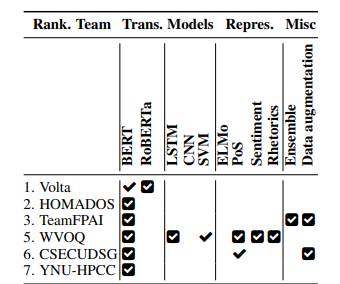

There are many options available, and in the competition, most participants used transformer-based models like BERT to extract text features. However, because of our limited computational resources, running BERT can be challenging. Instead, we’ll use a smaller but competitive model: ALBERT, which is better suited for our situation while still providing strong performance.

### Load data for ALBERT

Since transformer-based models rely on their own specific tokenizers, we will need to use ALBERT's tokenizer to preprocess the text before feeding it into the model. The tokenizer breaks down the text into subword tokens, which the model can interpret. However, the spans provided in the dataset are on a character-level, while transformer models like ALBERT operate at the token-level. This mismatch requires us to transform the character-level spans into token-level spans to ensure proper alignment between the input data and the model.

To do this, we map each character span to its corresponding token in the tokenized text. By transforming the spans from character-based indices to token-based indices, we ensure that the model processes the data accurately and can focus on the correct parts of the input text. This step is crucial for maintaining consistency between the dataset and the model's token-based architecture

In [51]:
texts = [sample['text'] for sample in train_json + test_json + dev_json]
len(texts)

752

In [52]:
# Get the longest sequence after tokenized
albert_model_name = 'albert-large-v2'
albert_tokenizer = AutoTokenizer.from_pretrained(albert_model_name)

# Get the maximum sequence length
lengths = []

for text in texts:
    lengths.append(len(albert_tokenizer.encode(text, add_special_tokens=False)) + 2)

# Get max length for padding
max_len = max(lengths)

c:\Users\LENOVO\anaconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [53]:
label_to_index = {label: idx for idx, label in enumerate(techniques)}
label_to_index

{'Appeal to authority': 0,
 'Appeal to fear/prejudice': 1,
 'Black-and-white Fallacy/Dictatorship': 2,
 'Causal Oversimplification': 3,
 'Doubt': 4,
 'Exaggeration/Minimisation': 5,
 'Flag-waving': 6,
 'Glittering generalities (Virtue)': 7,
 'Loaded Language': 8,
 "Misrepresentation of Someone's Position (Straw Man)": 9,
 'Name calling/Labeling': 10,
 'Obfuscation, Intentional vagueness, Confusion': 11,
 'Presenting Irrelevant Data (Red Herring)': 12,
 'Reductio ad hitlerum': 13,
 'Repetition': 14,
 'Slogans': 15,
 'Smears': 16,
 'Thought-terminating cliché': 17,
 'Whataboutism': 18,
 'Bandwagon': 19}

In [ ]:
# Get index to label
index_to_label = {v: k for k, v in label_to_index.items()}
index_to_label

Tokenize and encode text, labels on token level

In [55]:
def tokenize_and_encode_labels(example, tokenizer, label_to_index, max_length=max_len):
    # Tokenize the text
    encoding = tokenizer(example['text'], padding='max_length', truncation=True, max_length=max_length, return_offsets_mapping=True)
    
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    offset_mapping = encoding['offset_mapping']  # Maps tokens to character spans

    # Initialize label arrays
    labels = [[0] * len(label_to_index) for _ in range(len(input_ids))]  # Multi-label binary for each token

    # Map the character-based labels to the tokenized version
    for label in example['labels']:
        start_char, end_char = label['start'], label['end']
        label_name = label['technique']
        
        # Find the tokens that correspond to this character span
        for idx, (start_token, end_token) in enumerate(offset_mapping):
            if input_ids[idx] in tokenizer.all_special_ids:
                continue  # Ignore special tokens
            
            if start_token >= start_char and end_token <= end_char:
                labels[idx][label_to_index[label_name]] = 1  # Multi-label classification
    
    return input_ids, attention_mask, labels

In [56]:
def to_ds(data, tokenizer, label_to_index, max_length=max_len, shuffle=True):
    input_ids_list, attention_mask_list, label_list = [], [], []

    for example in data:
        input_ids, attention_mask, labels = tokenize_and_encode_labels(example, tokenizer, label_to_index, max_length)
        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        label_list.append(labels)

    input_ids_tensor = tf.constant(input_ids_list)
    attention_mask_tensor = tf.constant(attention_mask_list)
    label_tensor = tf.constant(label_list)

    dataset = tf.data.Dataset.from_tensor_slices(((input_ids_tensor, attention_mask_tensor), label_tensor))
    dataset = dataset.shuffle(len(data)) if shuffle else dataset
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [57]:
train_ds = to_ds(train_json, albert_tokenizer, label_to_index, shuffle=True)
test_ds = to_ds(test_json, albert_tokenizer, label_to_index)
dev_ds = to_ds(dev_json, albert_tokenizer, label_to_index)

The correct shape for each input_id and label should be (sequence_length,) and (sequence_length, number_of_labels) respectively

In [91]:

def vis_ds(ds):
    for data, labels in ds.take(1):
        input_ids, attention_mask = data
        input_id = input_ids[0].numpy()
        label = labels[0].numpy()
        decoded_text = albert_tokenizer.decode(input_id, skip_special_tokens=True)

        # Visualize the labels per token
        token_labels = []
        for i, token_id in enumerate(input_id):
            # Skip special tokens (e.g., [PAD])
            if token_id == albert_tokenizer.pad_token_id:
                continue
            
            # Get the labels for the current token
            active_labels = [index_to_label[idx] for idx, value in enumerate(label[i]) if value == 1]
            token = albert_tokenizer.decode([token_id])
            
            if active_labels:
                token_labels.append((token, active_labels))

        print(f"Decoded text: {decoded_text}")
        
        for token, token_label in token_labels:
            print(f"Token: '{token}', Labels: {', '.join(token_label)}")

In [92]:
vis_ds(train_ds)

Decoded text: could those of you saying that someone losing a twitter account is akin to life under the nazis kindly stfu?
Token: 'st', Labels: Loaded Language, Thought-terminating cliché
Token: 'fu', Labels: Loaded Language, Thought-terminating cliché


After visualizing samples from the dataset, it became clear that a single span can have multiple overlapping labels. This makes NER approaches like BIOS (Begin, Inside, Outside, Single) unsuitable. BIOS assumes that each token or span has one contiguous label, which works well for single-label tasks but fails when multiple labels apply to the same span. In multi-label scenarios, where spans can have concurrent or overlapping labels, BIOS cannot accurately represent all the labels due to its reliance on strict boundary markers (e.g., beginning, inside). As a result, it can lead to misclassification or loss of important label information, making it impractical for tasks requiring multi-label classification at the span level. Therefore, this further emphasize the need to tranform the span to token-level

### Train

In [65]:
def create_model(pretrained_name='albert-large-v2'):
    # ALBERT model
    albert_model = TFAutoModel.from_pretrained(pretrained_name)
    albert_model.trainable = False
    
    # Text branch
    input_ids = layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
    text_embeddings = albert_model(input_ids, attention_mask=attention_mask)[0]  # Output hidden states
    logits = tf.keras.layers.Dense(len(techniques), activation='sigmoid')(text_embeddings)  
    
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=logits)
    
    return (model, albert_model)

In [61]:
baseline, albert = create_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
baseline.compile(optimizer=optimizer, 
                loss=losses.BinaryFocalCrossentropy(from_logits=False), metrics=get_metrics())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [62]:
baseline_history = baseline.fit(train_ds, validation_data=dev_ds, epochs=50, callbacks=get_cbs(), verbose=False)

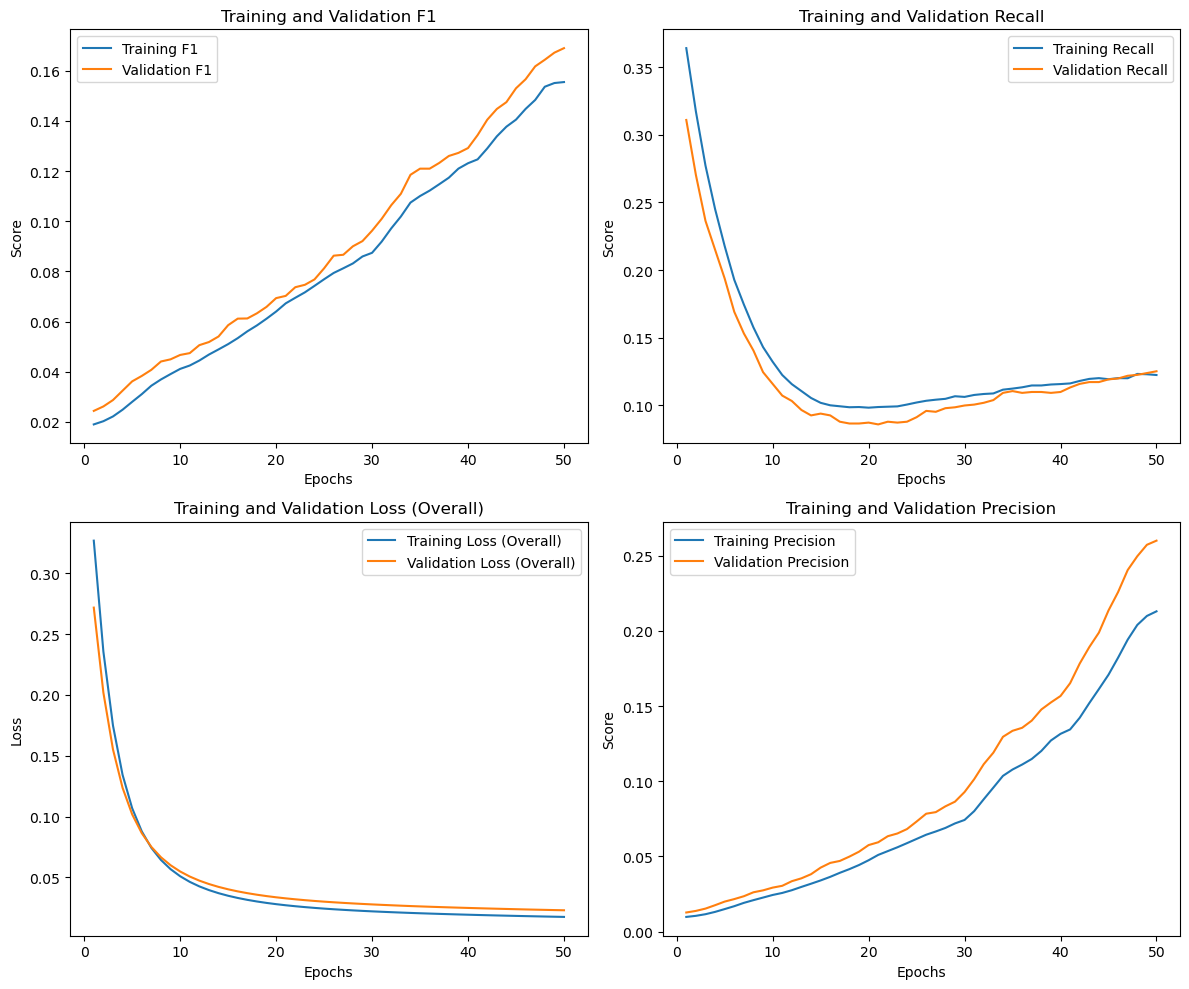

In [63]:
plot_history(baseline_history)

**OBSERVATIONS**

When analyzing the model's performance, we observe that although the F1 score is improving and the loss is decreasing, there are slight signs of overfitting. More importantly, we see that recall is declining, which means the model is becoming more cautious and is missing more true positives. In other words, it’s failing to identify some of the relevant instances. At the same time, precision is increasing, indicating that the model is making fewer positive predictions but doing so with greater accuracy.

This behavior is expected in an imbalanced dataset. The model is naturally focusing more on the majority classes, which are more frequent, and becoming better at identifying them. Even though we’ve used Focal Loss to help the model focus on minority classes, it remains a challenge to capture these less common labels effectively. As a result, precision improves quickly, but recall suffers because the model struggles to correctly identify the minority classes.

This issue may be due to threshold sensitivity. In imbalanced datasets, adjusting the decision threshold (the cutoff point for classifying an instance as positive) can result in a trade-off between precision and recall. If the threshold is set too high to reduce false positives, precision improves, but the model becomes overly cautious and recall decreases. This is particularly problematic for minority classes, where the model is already less likely to make positive predictions.

Our goal is to create a more balanced model where both precision and recall improve. To achieve this, we need the model to better identify minority classes without being overly cautious. Tuning the decision threshold can help strike this balance by encouraging the model to make more positive predictions for minority classes while maintaining accuracy. Once we further improve the overall model performance (e.g., F1 score), we can fine-tune the threshold to enhance both recall and precision, ensuring the model captures more relevant instances without sacrificing accuracy

**NEXT STEP**

In the next step, we will work on rebalancing the Precision-Recall tradeoff by experimenting with label smoothing and adjusting the parameters of Focal Loss. These changes aim to prevent overconfidence in predictions and help the model improve recall, especially for minority classes.

**Focal Loss Adjustments**:

We will use alpha > 1 to increase the loss contribution from positive examples. This adjustment will help the model pay more attention to underrepresented classes, which should improve recall for positive examples. The goal is to guide the model to better recognize minority labels without neglecting the majority classes.
We won’t modify gamma, as it controls the focus on hard-to-classify instances. Since minority classes aren't necessarily harder to classify, leaving gamma unchanged ensures we don’t unintentionally focus more on the easy or difficult examples at the expense of other important aspects.

**Label Smoothing**:


We'll implement label smoothing with a value of 0.1, which is commonly used in state-of-the-art transformer models like BERT and T5. Label smoothing helps prevent the model from becoming overconfident in its predictions by assigning a small amount of probability to incorrect labels. This encourages the model to generalize better and can reduce overfitting, making it less likely to overly focus on any particular class.
By combining these approaches, we aim to fine-tune the balance between precision and recall, particularly improving the model's ability to identify underrepresented (minority) classes while avoiding overconfidence in the predictions for more frequent classes.

## Recall-Precision tradeoff

In [128]:
model, albert = create_model(pretrained_name='albert-large-v2')
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
model.compile(optimizer=optimizer, 
                loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1, alpha=1.2), metrics=get_metrics())

c:\Users\LENOVO\anaconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification

In [129]:
history = model.fit(train_ds, validation_data=dev_ds, epochs=50, callbacks=get_cbs(), verbose=False)

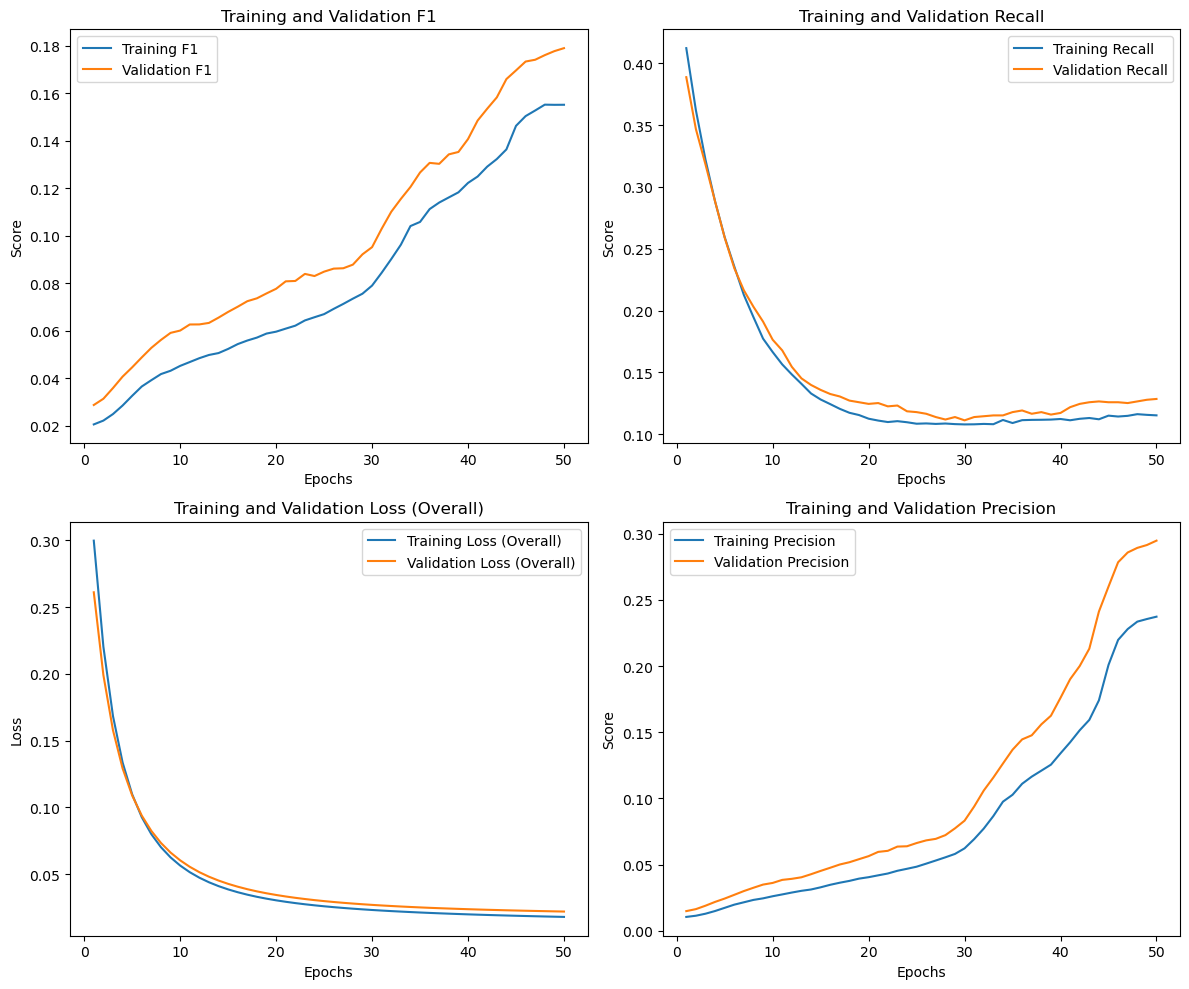

In [130]:
plot_history(history)

From the plot, we observe that adding label smoothing and increasing alpha have a modest impact on Recall. Given that both alpha and label smoothing are tunable hyperparameters, we can further optimize these values to find the best combination that maximizes Recall.

By systematically testing different combinations of alpha and label smoothing, we aim to identify the optimal settings that enhance the model's ability to correctly identify positive examples, particularly for underrepresented classes. This process will help us fine-tune the balance between precision and recall, improving the model's overall performance, especially in terms of Recall.

### Hyperparameter tuning

Since we can adjust the thresholds separately, we won’t focus on that aspect in this step. Additionally, due to the extended training time required for ALBERT large, we’ll switch to the smaller ALBERT-base model for the text component to save time and improve efficiency.

For optimization, we will focus on both precision and recall. By improving these two metrics, we can naturally enhance the model's F1 score, as it is the harmonic mean of precision and recall. This approach ensures a balanced model performance, especially in handling both majority and minority classes.

In [99]:
def objective(trial):
    clear_session()
    
    label_smoothing = trial.suggest_float("label_smoothing", 0.1, 0.3, step=0.1)
    alpha = trial.suggest_float("alpha", 1.0, 2.0, step=0.2)
    
    model, _ = create_model(pretrained_name='albert-base-v2')

    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=label_smoothing, alpha=alpha), 
                  metrics=get_metrics())
    
    model.fit(train_ds, validation_data=dev_ds, epochs=20, callbacks=get_cbs(), verbose=False)
    score = model.evaluate(dev_ds, verbose=False)
    
    return score[2], score[3]

In [100]:
study_name="meme_tagger"
storage_name="sqlite:///{}.db".format(study_name)

In [102]:
study = optuna.create_study(directions=["maximize", "maximize"], 
                            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                            study_name=study_name, storage=storage_name, load_if_exists=True)

[I 2024-10-04 16:38:06,442] Using an existing study with name 'meme_tagger' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=20)

In [111]:
# Get the best trial
study.best_trials[0]

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[0.08853410929441452, 0.16245006024837494], datetime_start=datetime.datetime(2024, 10, 4, 16, 56, 22, 390974), datetime_complete=datetime.datetime(2024, 10, 4, 16, 59, 21, 353925), params={'label_smoothing': 0.1, 'alpha': 1.2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'label_smoothing': FloatDistribution(high=0.3, log=False, low=0.1, step=0.1), 'alpha': FloatDistribution(high=2.0, log=False, low=1.0, step=0.2)}, trial_id=9, value=None)

We will choose label_smoothing = 0.1 and alpha = 1.2 as it offers a balance between recall and precision score

## Fine tuning

In this step, we’ll fine-tune ALBERT large using the parameters we defined earlier. Initially, we will train ALBERT with its layers frozen, allowing only the task-specific layers to be updated. This helps the model learn how to integrate text features without altering the pretrained weights too early.

After this initial phase, we’ll unfreeze ALBERT and continue training, but with a smaller learning rate. This strategy enables more gradual updates to the model, ensuring that the fine-tuning process refines ALBERT’s understanding of the dataset without disrupting the pretrained knowledge it brings. This two-phase approach aims to optimize the model's performance while avoiding overfitting or drastic weight updates

In [134]:
model, albert = create_model(pretrained_name='albert-large-v2')

albert.trainable = False

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1, alpha=1.2), 
                metrics=get_metrics())

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience=5)

history = model.fit(train_ds, validation_data=dev_ds, epochs=50, callbacks=get_cbs(), verbose=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


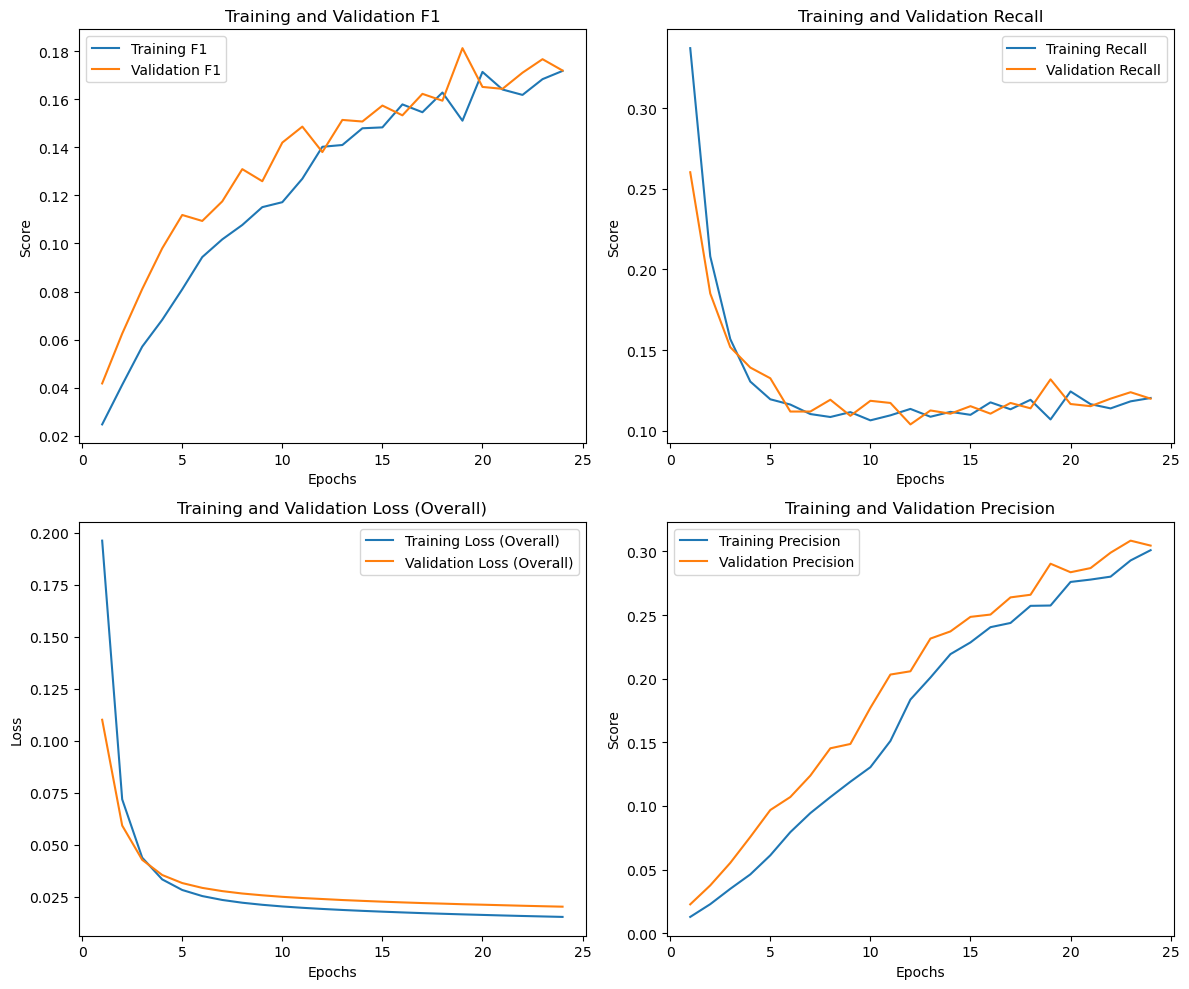

In [135]:
plot_history(history)

In [136]:
# Unfreeze the model and retrain
albert.trainable = True

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-6)
model.compile(optimizer=optimizer, loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1, alpha=1.2), 
                metrics=get_metrics())

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience=5)

history = model.fit(train_ds, validation_data=dev_ds, epochs=50, callbacks=get_cbs(), verbose=False)

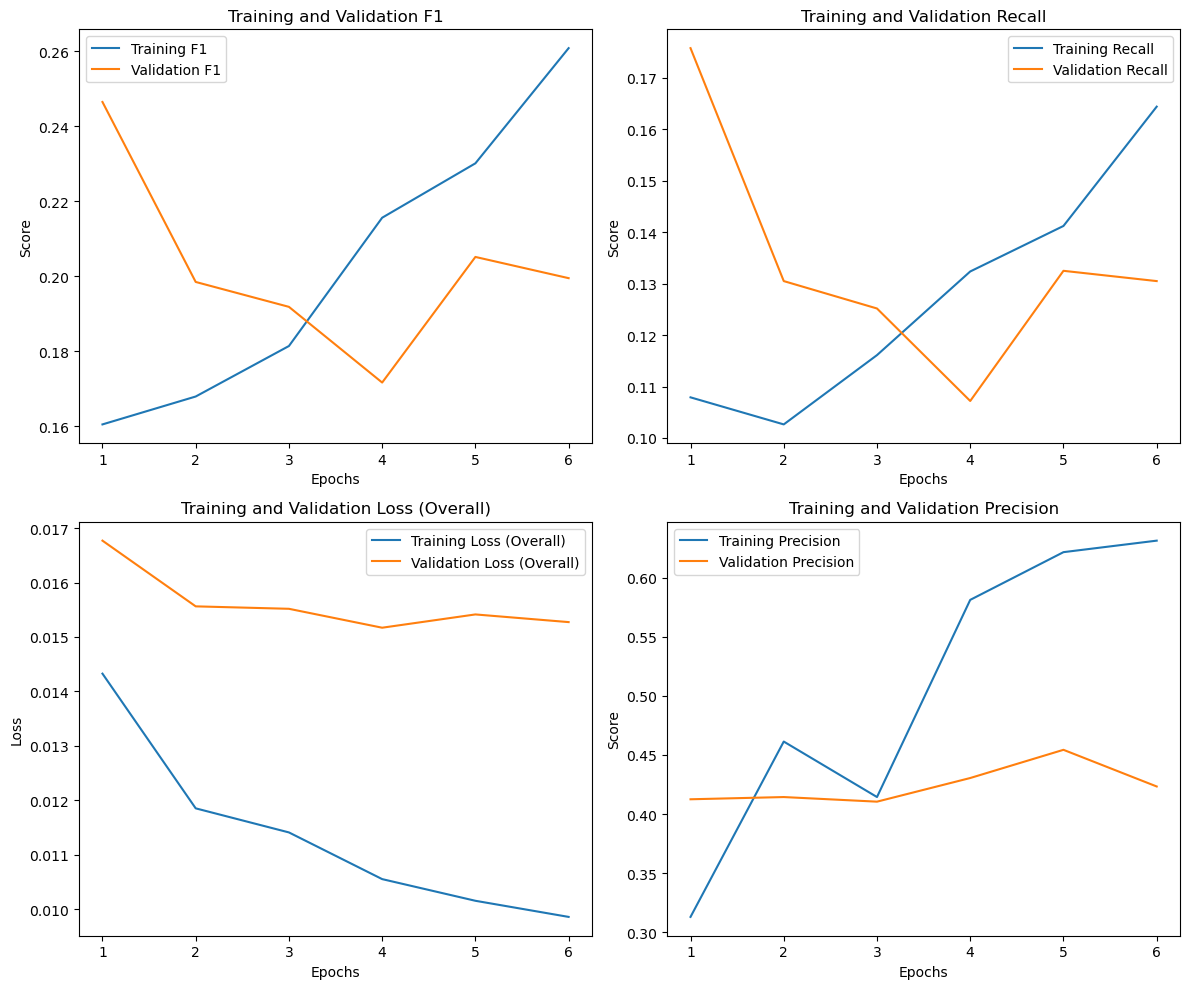

In [137]:
plot_history(history)

In [200]:
model.evaluate(dev_ds)

12/12 [==============================] - 1s 77ms/step - loss: 0.0168 - F1: 0.2465 - Precision: 0.4125 - Recall: 0.1758


[0.016769034788012505,
 0.24649859964847565,
 0.4124999940395355,
 0.17576564848423004]

During fine-tuning, we employed early stopping, which triggered before the model began to overfit. This was beneficial as it prevented the model from learning irrelevant noise, resulting in a well-tuned overall performance. With the new hyperparameters and fine-tuning, the model showed improvement in both recall and precision compared to previous versions. While the precision now exceeds our initial target, the recall is still lower than desired, and our goal is to achieve a better balance between the two.

One potential reason for the slower improvement in recall could be the strict decision threshold of 0.5, combined with the unbalanced nature of the data. To address this, we can adjust the threshold to find a value that better balances recall and precision. By fine-tuning the threshold, we aim to improve recall without sacrificing precision, ensuring that the model performs well in both areas for a more balanced performance overall

## Threshold tuning

In [304]:
def get_metrics_with_threshold(threshold=0.5):
    return [
        tfa.metrics.F1Score(num_classes=len(techniques), threshold=threshold, name="F1", average='micro'), 
        tf.keras.metrics.Precision(name="Precision", thresholds=threshold),
        tf.keras.metrics.Recall(name="Recall", thresholds=threshold),
    ]

In [311]:
thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores = []
precision_scores = []
recall_scores = []

best_f1_score = 0
best_threshold = 0.5

# Try all threshold and record the results
for threshold in thresholds:
    optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-6)
    model.compile(optimizer=optimizer, loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1, alpha=1.2), 
                    metrics=get_metrics_with_threshold(threshold=threshold))

    score = model.evaluate(dev_ds, verbose=False)
    
    if score[1] > best_f1_score:
        best_f1_score = score[1]
        best_threshold = threshold
        
    f1_scores.append(score[1])
    precision_scores.append(score[2])
    recall_scores.append(score[3])
    
    print(f"Threshold: {threshold:.4f}, F1: {score[1]:.4f}, Precision: {score[2]:.4f}, Recall: {score[3]:.4f}")

Threshold: 0.1000, F1: 0.1298, Precision: 0.0698, Recall: 0.9168
Threshold: 0.1500, F1: 0.1672, Precision: 0.0930, Recall: 0.8242
Threshold: 0.2000, F1: 0.2122, Precision: 0.1249, Recall: 0.7031
Threshold: 0.2500, F1: 0.2644, Precision: 0.1695, Recall: 0.6005
Threshold: 0.3000, F1: 0.3171, Precision: 0.2299, Recall: 0.5107
Threshold: 0.3500, F1: 0.3465, Precision: 0.2858, Recall: 0.4401
Threshold: 0.4000, F1: 0.3450, Precision: 0.3289, Recall: 0.3628
Threshold: 0.4500, F1: 0.3159, Precision: 0.3700, Recall: 0.2756
Threshold: 0.5000, F1: 0.2465, Precision: 0.4125, Recall: 0.1758
Threshold: 0.5500, F1: 0.1570, Precision: 0.4337, Recall: 0.0959
Threshold: 0.6000, F1: 0.0770, Precision: 0.4667, Recall: 0.0419
Threshold: 0.6500, F1: 0.0387, Precision: 0.6383, Recall: 0.0200
Threshold: 0.7000, F1: 0.0119, Precision: 0.6000, Recall: 0.0060
Threshold: 0.7500, F1: 0.0040, Precision: 0.6000, Recall: 0.0020
Threshold: 0.8000, F1: 0.0013, Precision: 1.0000, Recall: 0.0007
Threshold: 0.8500, F1: 0.

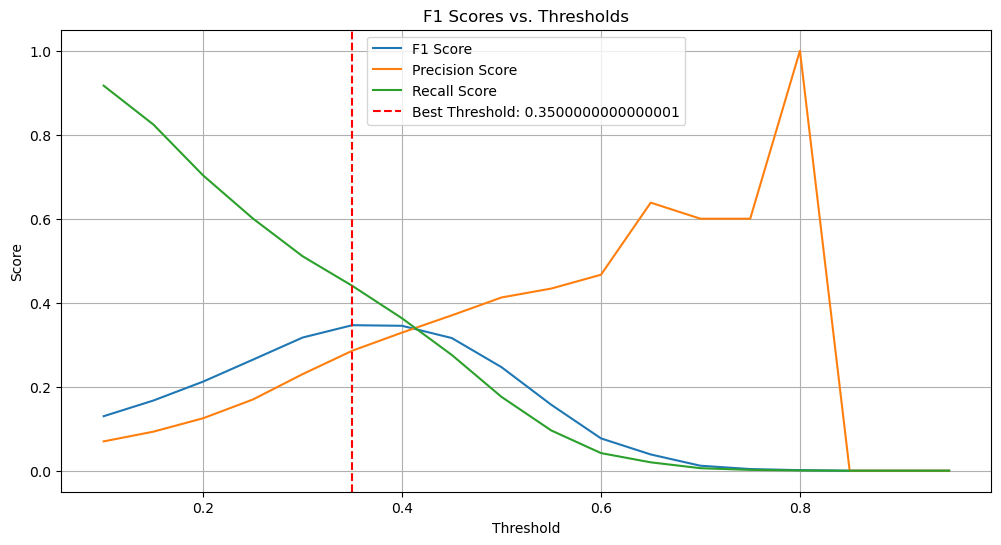

In [313]:
# Plot to compare thresholds
plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precision_scores, label='Precision Score')
plt.plot(thresholds, recall_scores, label='Recall Score')

# Highlight the best threshold
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold}')

plt.title('F1 Scores vs. Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)

plt.show()

Although a threshold of 0.35 yields the highest F1 score, we will select a threshold of 0.4 as our final choice. This decision is based on the fact that it provides a better balance between precision and recall, with both metrics around 0.3. Using this threshold ensures a more balanced trade-off between correctly identifying positive cases (precision) and capturing as many relevant cases as possible (recall). With this balanced approach, we aim to improve the overall effectiveness of the model. Next, we will evaluate the model using the chosen threshold of 0.4 to assess its performance under these conditions.

## Evaluation

We will evaluate our model with the new threshold we have selected

In [317]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-6)
model.compile(optimizer=optimizer, loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1, alpha=1.2), 
                metrics=get_metrics_with_threshold(threshold=0.4))

model.evaluate(test_ds, verbose=True)

40/40 [==============================] - 8s 78ms/step - loss: 0.0145 - F1: 0.2783 - Precision: 0.2627 - Recall: 0.2959


[0.01450221799314022,
 0.27829086780548096,
 0.26266852021217346,
 0.2958889901638031]

In [353]:
vis_pred(model, test_ds, threshold=0.4)

Decoded text: everyone wants me to read the constitution but it's written in cursive

Token          True Labels                   
everyone       Smears                        
wants          Smears                        
me             Smears                        
to             Smears                        
read           Smears                        
the            Smears                        
constitution   Smears                        
but            Smears                        
it             Smears                        
'              Smears                        
s              Smears                        
written        Smears                        
in             Smears                        
               Smears                        
----------------------------------------------------------------------------------------------------
Token          Predicted Labels              
everyone       
wants          
me             
to             
read         

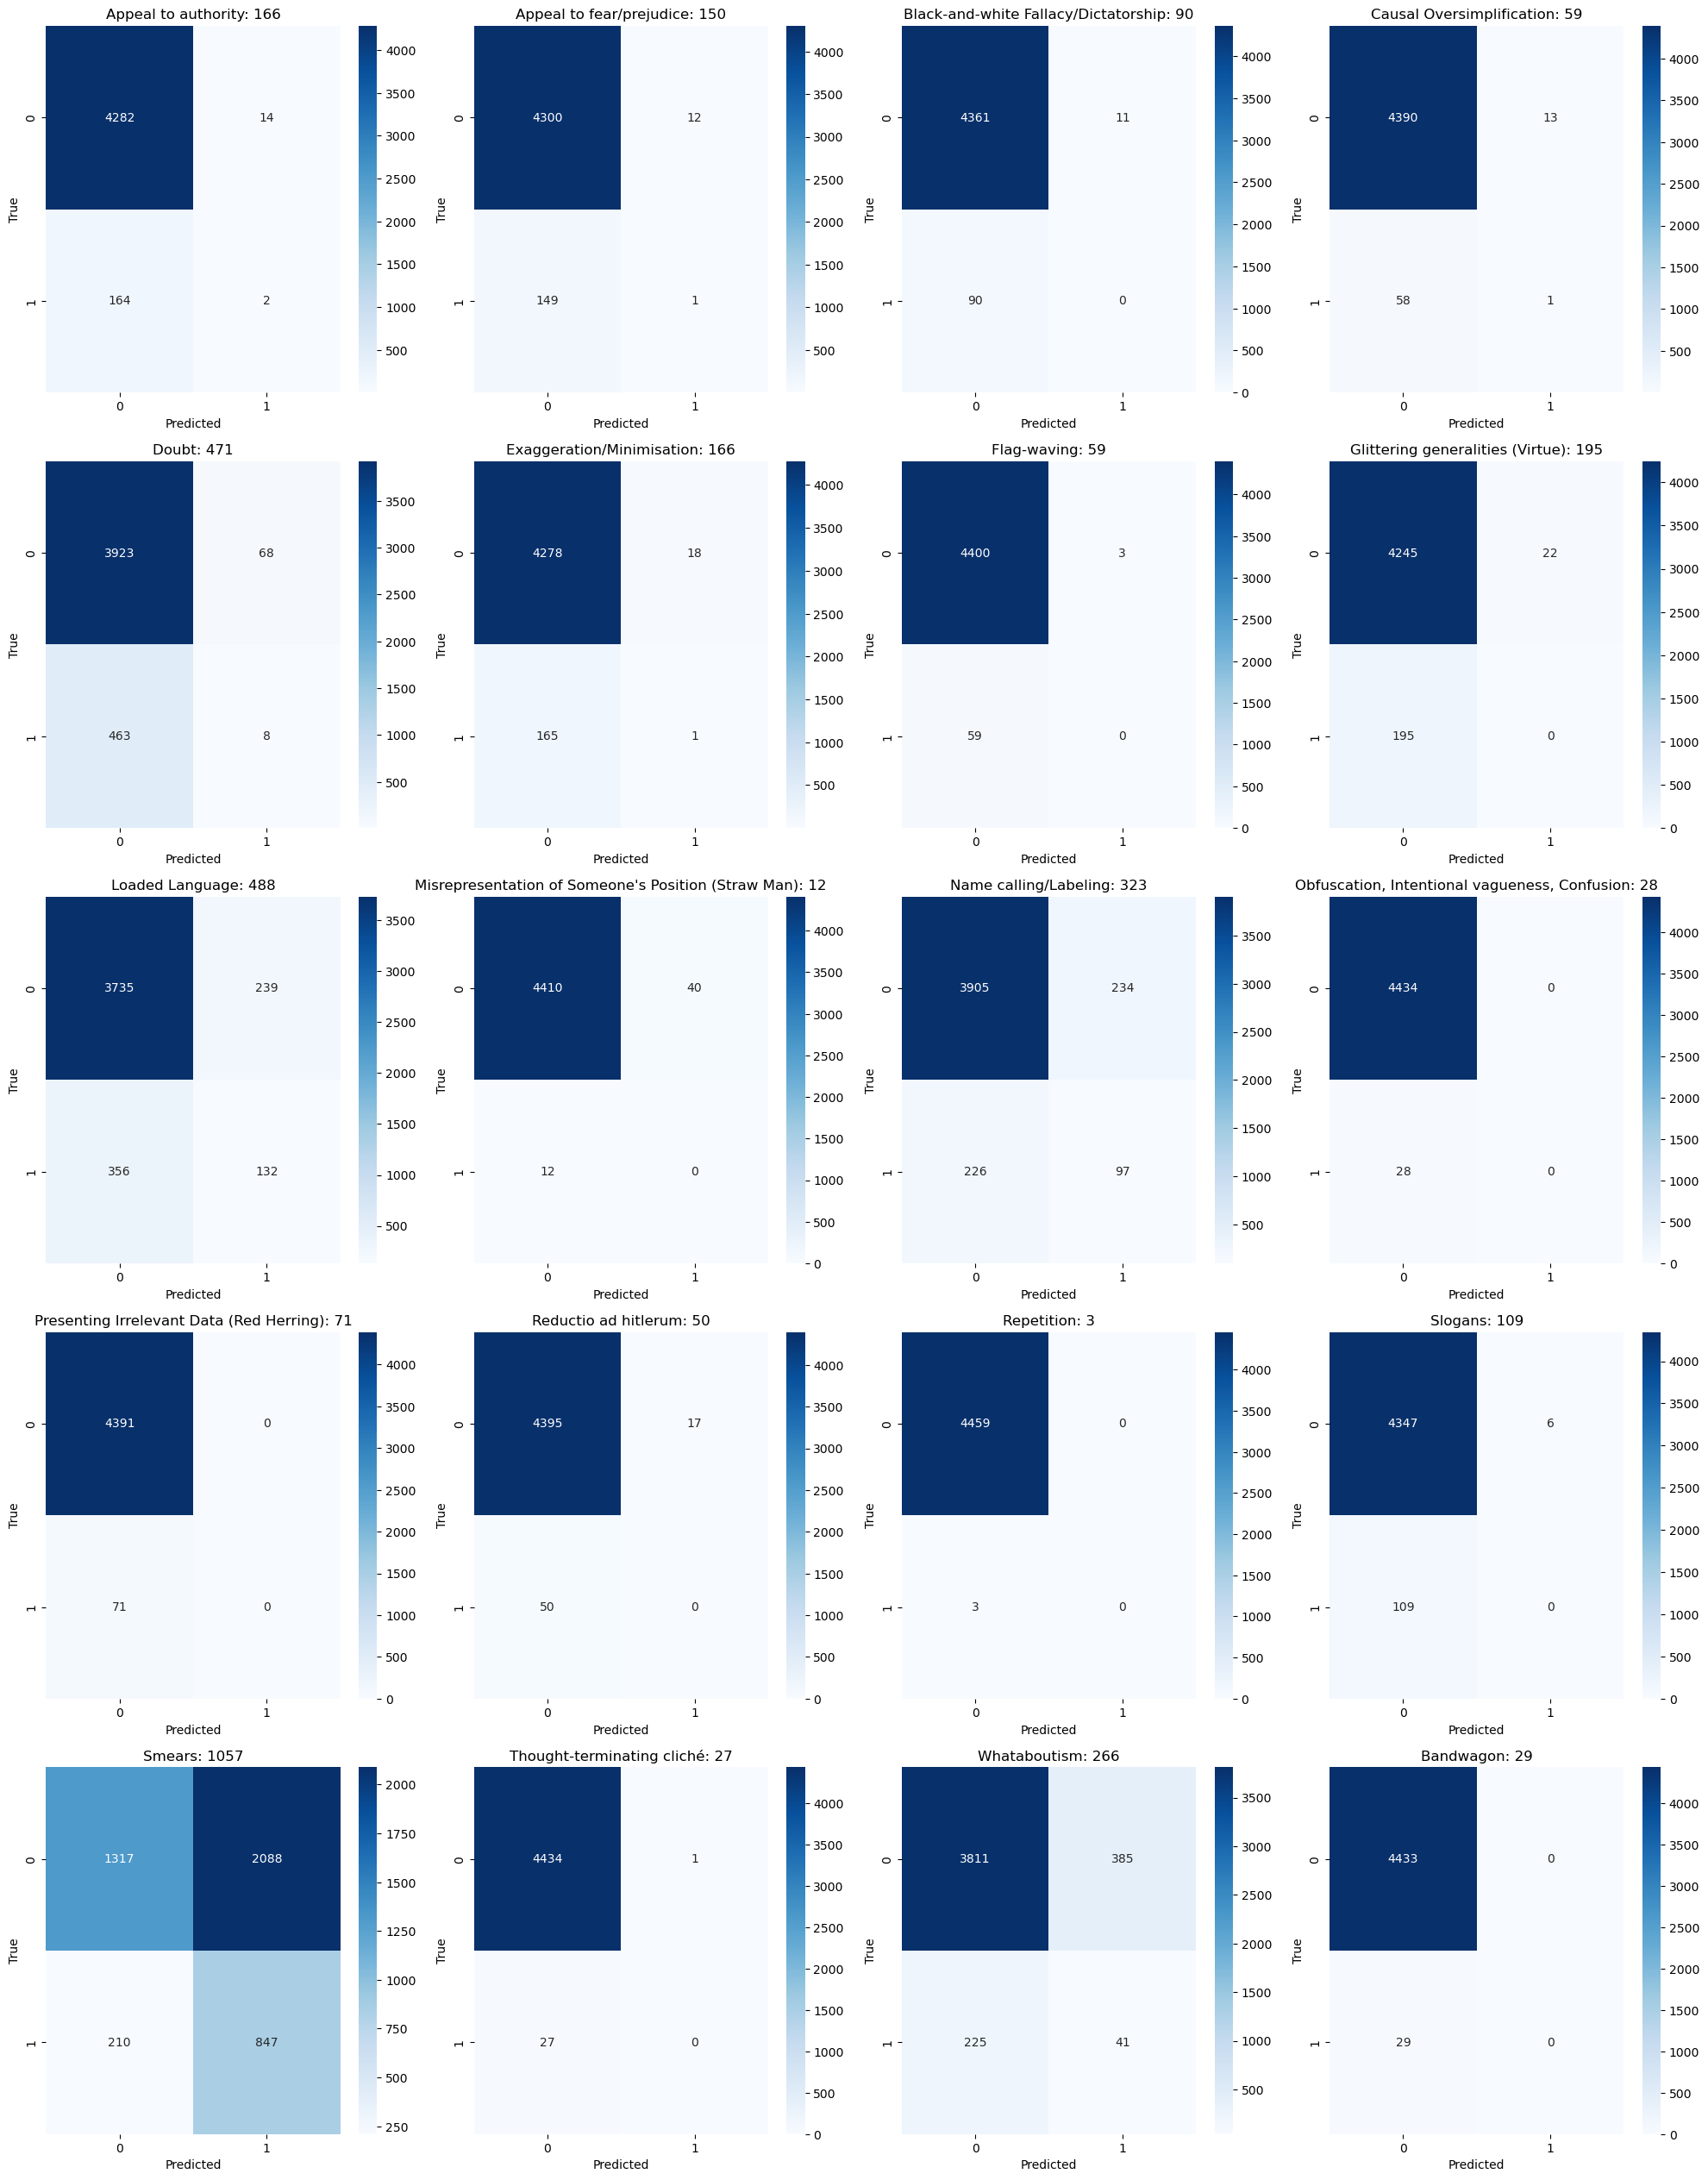

In [355]:
multilabel_heatmap(test_ds, model, threshold=0.4)

**OBSERVATION**

For many labels, the model struggles with correctly identifying positive cases, leading to a high number of false negatives. This indicates that the model frequently fails to detect when a label should be applied. For instance, labels like "Doubt" and "Loaded Language" are often under-predicted, meaning the model misses many real instances where these labels should be used.

Conversely, for some labels like "Smears" and "Name calling/Labeling", the model tends to over-predict, which results in a high number of false positives. In these cases, the model incorrectly labels instances as positive even when they aren’t, leading to inaccurate predictions.

For labels with very few examples in the dataset, such as "Misrepresentation of Someone’s Position" and "Thought-terminating cliché", the model struggles to recognize them at all, often making little to no correct predictions. This is understandable given the extreme imbalance in the dataset and the inherent challenge of the task, as the model has limited data to learn from for these underrepresented labels.

These issues highlight the difficulty in balancing predictions across both common and rare labels in an imbalanced dataset, where the model tends to perform better on frequent labels while struggling with underrepresented ones.

**DEEPER LOOK**

Upon closer examination of the model's predictions, we notice that for majority labels like "Smears," the model is generally successful in predicting that the label is present within the text. However, the challenge arises in accurately predicting all the relevant instances of this label. While the model identifies some occurrences of "Smears", it struggles to consistently apply the label to all the strings where it should be present. This inconsistency suggests that, while the model understands the overall patterns for majority labels, it still misses certain contexts or nuances where the label should apply

## Ultimate Judgement

### Final model selection

For the final model, I selected the version with ALBERT as the backbone and a decision threshold of 0.4. This choice was based on its balanced performance across key metrics, with recall, precision, and F1 score each scoring around 0.3 on the test dataset. This balance between precision and recall is crucial, as it ensures the model doesn't overly focus on majority classes while still capturing a reasonable number of true positives. Compared to the baseline, this model showed a notable improvement, particularly in recall, despite operating under limited computational resources.

The model successfully met, and in some areas, even surpassed my original goals for the task. It achieved higher scores across multiple metrics while maintaining a fair balance between correctly identifying positive instances and minimizing false positives. Importantly, the model avoided overemphasizing the majority classes, which is a common pitfall in imbalanced datasets.

However, despite these positive outcomes, there are still limitations that could be addressed in future iterations

### Real world challenges

Although the model met the initial performance targets, it is still not ready for real-world use. As seen from the heatmap and its predictions, the model frequently misses spans, even for majority classes. This inconsistency suggests that it struggles to reliably and consistently identify the correct labels, making it unreliable for practical applications.

To enhance the model's performance, particularly for minority classes and to improve the Macro F1 score, one potential solution is to switch to a more powerful language model like RoBERTa or DeBERTa. These models are larger, with superior performance on complex natural language tasks. They could offer more nuanced understanding of the text and help the model better capture rare labels. However, these models demand significantly more computational power, which might not be feasible with limited resources available on local machines.

Another approach to improve the model is to gather more data, especially for underrepresented labels. A more balanced dataset would give the model more examples to learn from, helping it generalize better and boosting performance on minority classes. However, collecting additional data can be time-consuming and costly, and may not always be a practical solution.

In summary, while the model shows promise, it requires further refinement through either more advanced models or data augmentation to achieve the reliability and accuracy needed for real-world deployment